# Transfer Learning Experiments

Created by: Jacob A Rose  
Created On: Wednesday Oct 6th, 2021  

Based on Notebook located at: https://jarvislabs.ai/blogs/transfer-learning

## Imports & Definitions

In [1]:
from rich import print as pp
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging

logger = logging.Logger(__name__)
logger.setLevel('INFO')

from tqdm.auto import tqdm, trange


%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
import glob
import hydra
from collections import OrderedDict
from typing import *

from lightning_hydra_classifiers.models.transfer import *
from rich import print as pp
from lightning_hydra_classifiers.utils.model_utils import count_parameters, collect_results
from lightning_hydra_classifiers.utils.metric_utils import get_per_class_metrics, get_scalar_metrics
from lightning_hydra_classifiers.models.backbones.backbone import build_model
import pytorch_lightning as pl

pl.seed_everything(42)

from lightning_hydra_classifiers.scripts.multitask.train import MultiTaskDataModule, LitMultiTaskModule, ImagePredictionLogger, train_task,  CIFAR10DataModule, run_multitask_test, load_data_and_model, load_data, resolve_config, configure_callbacks, configure_loggers, configure_trainer
from lightning_hydra_classifiers.data.datasets.common import toPIL
from lightning_hydra_classifiers.utils.etl_utils import ETL
from omegaconf import OmegaConf

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning_hydra_classifiers.scripts.pretrain import lr_tuner

from lightning_hydra_classifiers.scripts.multitask.train import configure_callbacks, configure_loggers#, configure_trainer

Global seed set to 42


## Developing Early Stopping multi-stage subclass for finetuning

### trying out built in lightning tests for fine tuning

In [2]:
# os.chdir(Path(pl.__file__).parent)
# os.getcwd()

In [3]:
# # %%writefile first_test.py

# # See the License for the specific language governing permissions and
# # limitations under the License.
# from collections import OrderedDict
# import matplotlib.pyplot as plt

# import pytest
# import torch
# from torch import nn
# from torch.optim import Optimizer, SGD
# from torch.utils.data import DataLoader

# from pytorch_lightning import LightningModule, seed_everything, Trainer
# from pytorch_lightning.callbacks import BackboneFinetuning, BaseFinetuning, ModelCheckpoint
# from pytorch_lightning.callbacks.base import Callback
# from tests.helpers import BoringModel, RandomDataset

# from typing import *

# # class RandomDataset(torch.utils.data.Dataset):
# #     def __init__(self, num_samples=2000, shape=(3,64,64)):
# #         self.num_samples = num_samples
# #         self.shape = shape
# #         self.data = torch.randn(num_samples, *shape)

# #     def __getitem__(self, index):
# #         return self.data[index]

# #     def __len__(self):
# #         return self.num_samples

# # class RandomTupleSupervisedDataset(RandomDataset):
    
# #     def __init__(self, num_classes=1000, num_samples=2000, shape=(3,64,64)):
# #         super().__init__(num_samples, shape)
# #         self.num_classes = num_classes
        
# #         self.targets = torch.randperm(num_classes)[:num_samples]
        
# #     def __getitem__(self, index):
# #         return self.data[index], self.targets[index]
        

# # dataset = RandomTupleSupervisedDataset(1000, 200, (3,128,128))
# # dataset
# # dataset.data.shape

# # class TestBackboneFinetuningCallback(BackboneFinetuning):
# #     def on_train_epoch_start(self, trainer, pl_module):
# #         super().on_train_epoch_start(trainer, pl_module)
# #         epoch = trainer.current_epoch
# #         if self.unfreeze_backbone_at_epoch <= epoch:
# #             optimizer = trainer.optimizers[0]
# #             current_lr = optimizer.param_groups[0]["lr"]
# #             backbone_lr = self.previous_backbone_lr
# #             if epoch < 6:
# #                 assert backbone_lr <= current_lr
# #             else:
# #                 assert backbone_lr == current_lr

# ###############################################################

# # class BackboneFinetuningCallback(pl.callbacks.Callback):

# #         def __init__(self,
    

# print("current dir:", os.getcwd())

# import os
# os.path.abspath

In [4]:
# %%writefile finetuning_callback_test.py

# import numpy as np
# import os
# import pytest
# from typing import *
# import pytorch_lightning as pl
# import torch
# from lightning_hydra_classifiers.models.transfer import *
# from torch.utils.data import DataLoader

# from torch import nn
# # from pytorch_lightning import LightningModule, seed_everything, Trainer
# import logging
# import json
# logging.basicConfig(level=logging.DEBUG)
# logger = logging.Logger(__name__)
# logger.setLevel('INFO')
# pylog = logging.getLogger()


# BN_TYPE = (torch.nn.modules.batchnorm._BatchNorm,)

# def is_bn(layer: nn.Module) -> bool:
#     """ Return True if layer's type is one of the batch norms."""
#     return isinstance(layer, BN_TYPE)

# def grad_check(tensor: torch.Tensor) -> bool:
#     """ Returns True if tensor.requires_grad==True, else False."""
#     return tensor.requires_grad == True


# # os.chdir("/media/data/jacob/GitHub/lightning-hydra-classifiers")#/tests")

# class RandomDataset(torch.utils.data.Dataset):
#     def __init__(self, num_samples=2000, shape=(3,64,64)):
#         self.num_samples = num_samples
#         self.shape = shape
#         self.data = torch.randn(num_samples, *shape)

#     def __getitem__(self, index):
#         return self.data[index]

#     def __len__(self):
#         return self.num_samples

# class RandomTupleSupervisedDataset(RandomDataset):
    
#     def __init__(self, num_classes=1000, num_samples=2000, shape=(3,64,64)):
#         super().__init__(num_samples, shape)
#         self.num_classes = num_classes
        
#         self.targets = torch.randperm(num_classes)[:num_samples]
        
#     def __getitem__(self, index):
#         return self.data[index], self.targets[index]

##############################################

    
    
# class FinetuningLightningCallback(pl.callbacks.Callback):
    
# # class FinetuningLightningPlugin:
#     mode_dict = {"min": torch.lt, "max": torch.gt}
#     order_dict = {"min": "<", "max": ">"}
    
    
#     def __init__(self,
#                  monitor: str="val_loss",
#                  mode: str="min",
#                  patience: int=4):
        
# #         if pl_module.hparams.finetuning_strategy == "finetuning_unfreeze_layers_on_plateau":
#         self.monitor = monitor
#         self.mode = mode
#         self.patience = patience
# #         self.best_metric = 0
#         self.milestone_index = 0
        
# #         self.min_delta *= 1 if self.monitor_op == torch.gt else -1
#         torch_inf = torch.tensor(np.Inf)
#         self.best_score = torch_inf if self.monitor_op == torch.lt else -torch_inf
    
#         self.milestone_logs = []
        
#     def on_fit_start(self,
#                      trainer,
#                      pl_module):
#         self.milestones = pl_module.finetuning_milestones
#         print(f"Setting milestones: {pl_module.finetuning_milestones}")
#         self._finished = False
    
    
#     def finetuning_pretrained_strategy(self,
#                                        trainer: "pl.Trainer",
#                                        pl_module):
#         """
        
        
#         """
#         epoch = trainer.current_epoch
#         logs = trainer.callback_metrics
#         current = logs.get(self.monitor)
        
#         if self.mode == "min":
#             new_best = current < self.best_score
#         elif self.mode == "max":
#             new_best = current > self.best_score
        
#         if self._finished:
#             return
        
#         if new_best:
#             self.best_score = current
#             self.wait_epochs = 0
#             print(f"New best score: {self.monitor}={self.best_score}.")
#         elif self.wait_epochs >= self.patience:
            
#             next_to_unfreeze = self.milestones[self.milestone_index]
#             print(f"Patience of {self.patience} surpassed at epoch: {epoch} unfreezing down to: {next_to_unfreeze}")
            
#             pl_module.unfreeze_backbone_top_layers(unfreeze_down_to=next_to_unfreeze)
#             self.wait_epochs = 0
#             self.milestone_index += 1
#             self.milestone_logs.append({"epoch":epoch,
#                                         "unfreeze_at_layer":next_to_unfreeze,
#                                         "trainable_params":pl_module.get_trainable_parameters(count_params=True),
#                                         "nontrainable_params":pl_module.get_nontrainable_parameters(count_params=True)})
#             if self.milestone_index >= len(self.milestones):
#                 self._finished = True
#         else:
#             self.wait_epochs += 1
    
#     @property
#     def monitor_op(self) -> Callable:
#         return self.mode_dict[self.mode]
    
#     def on_epoch_end(self, trainer, pl_module):
#         """Called when the epoch ends."""

#         self.finetuning_pretrained_strategy(trainer=trainer, pl_module=pl_module)
#         try:
#             pl_module.log("nontrainable_params", pl_module.get_nontrainable_parameters(count_params=True))
#             pl_module.log("trainable_params", pl_module.get_trainable_parameters(count_params=True))
# #             pl_module.logger.summary["milestones"] = self.milestone_logs[-1]
#         except Exception as e:
#             print(e)
#             print(f"logging to wandb didnt work bro")



########################
########################


from lightning_hydra_classifiers.callbacks.finetuning_callbacks import FinetuningLightningCallback

class TestLightningClassifier(LightningClassifier):

    def __init__(self,
                 backbone_name='resnet50',
                 pretrained: Union[bool, str]=True,
                 num_classes: int=1000,
                 finetuning_strategy: str="feature_extractor",
                 seed: int=None,
                 **kwargs):

        super().__init__(backbone_name=backbone_name,
                         pretrained=pretrained,
                         num_classes=num_classes,
                         pool_type="avgdrop",
                         head_type="linear",
                         hidden_size=None, lr=0.01, backbone_lr_mult=0.1,
                         weight_decay=0.01,
                         finetuning_strategy=finetuning_strategy,
                         seed=42,
                        **kwargs)
        self._verbose=True
        
        
    
        
    def training_step(self, batch, batch_idx):
        self.log("train_loss",1)
        return {"loss": torch.ones(1, requires_grad=True)}
    
    def validation_step(self, batch, batch_idx):
        self.log("val_loss",1)
        return {"loss": torch.ones(1, requires_grad=True)}
    
    
#         output = super().training_step(batch, batch_idx)
#         self._verbose=False
#         return output

    def training_step_end(self, outputs):
        super().training_step_end(outputs)

    def print(self, *args):
        if self._verbose:
            print(*args)

    def train_dataloader(self):
        return DataLoader(RandomTupleSupervisedDataset(num_classes=1000, num_samples=50, shape=(3,64,64)), batch_size=2)

    def val_dataloader(self):
        return DataLoader(RandomTupleSupervisedDataset(num_classes=1000, num_samples=50, shape=(3,64,64)), batch_size=2)


def save_log(log, fp):
    with open(fp, "w") as fp:
        json.dump(log, fp, indent=4, sort_keys=False)

        
        
        
###############################
###############################


# @pytest.mark.parametrize("finetuning_strategy",
#                         [("feature_extractor",)
#                          "feature_extractor_+_bn.eval()",
#                          "feature_extractor_+_except_bn"])

# @pytest.mark.parametrize("finetuning_strategy, expected_layer_counts",
#     [
#         ("feature_extractor",
#             {"is_training":{'True': 53, 'False': 0, 'Total': 53}, 
#              "requires_grad":{'True': 0, 'False': 53, 'Total': 53}}
#         ),
#         ("feature_extractor_+_bn.eval()",
#             {"is_training":{'True': 0, 'False': 53, 'Total': 53}, 
#              "requires_grad":{'True': 0, 'False': 53, 'Total': 53}}
#         ),
#         ("feature_extractor_+_except_bn",
#             {"is_training":{'True': 53, 'False': 0, 'Total': 53}, 
#              "requires_grad":{'True': 53, 'False': 0, 'Total': 53}}
#         )
#     ]
#                         )
# @pytest.mark.parametrize()
def test_finetuning_callback(tmpdir):#, finetuning_strategy: str, expected_layer_counts: Dict[str,Dict[str,int]]):#, expectations: Dict[str,Any]):
    """Test finetuning strategy works as expected."""

    pl.seed_everything(42)
    
    callbacks = [FinetuningLightningCallback(monitor="val_loss",
                                             mode="min",
                                             patience=4)]

    model = TestLightningClassifier(finetuning_strategy="finetuning_unfreeze_layers_on_plateau")
#     callback = TestBackboneFinetuningCallback(unfreeze_backbone_at_epoch=3, verbose=False)

    trainer = pl.Trainer(limit_train_batches=2,
                         limit_val_batches=2,
                         default_root_dir="/home/jrose3",
                         log_every_n_steps=1,
                         callbacks=callbacks,
                         max_epochs=25)
    trainer.fit(model)
    
    
#     pylog.info(f"strategy: {finetuning_strategy}")
    model._verbose = True
    layer_counts = model.count_trainable_batchnorm_layers()



    from rich import print as pp
    print("milestone_logs:")
    pp(callbacks[0].milestone_logs)

#     pylog.info(f"strategy: {finetuning_strategy}")
#     pylog.info(f"Expected layer counts: {expected_layer_counts}")
    pylog.info(f"count trainable batchnorm layers`: {model.count_trainable_batchnorm_layers()}")
    pylog.info(f"count trainable layers: {model.get_trainable_parameters(count_layers=True)}")
    pylog.info(f"count nontrainable layers: {model.get_nontrainable_parameters(count_layers=True)}")
    pylog.info(f"count trainable params: {model.get_trainable_parameters(count_params=True)}")
    pylog.info(f"count nontrainable params: {model.get_nontrainable_parameters(count_params=True)}")

    
    
    
#     assert expected_layer_counts["is_training"]["True"] == layer_counts[0]["True"]
#     assert expected_layer_counts["is_training"]["False"] == layer_counts[0]["False"]

#     assert expected_layer_counts["requires_grad"]["True"] == layer_counts[1]["True"]
#     assert expected_layer_counts["requires_grad"]["False"] == layer_counts[1]["False"]

In [5]:
# model = TestLightningClassifier(finetuning_strategy="feature_extractor_+_except_bn")

In [6]:
# class TestLightningClassifier(LightningClassifier):

#     def __init__(self,
#                  backbone_name='resnet50',
#                  pretrained: Union[bool, str]=True,
#                  num_classes: int=1000,
#                  finetuning_strategy: str="feature_extractor",
#                  seed: int=None,
#                  **kwargs):

#         super().__init__(backbone_name=backbone_name,
#                          pretrained=pretrained,
#                          num_classes=num_classes,
#                          pool_type="avgdrop",
#                          head_type="linear",
#                          hidden_size=None, lr=0.01, backbone_lr_mult=0.1,
#                          weight_decay=0.01,
#                          finetuning_strategy=finetuning_strategy,
#                          seed=42,
#                         **kwargs)
#         self._verbose=True

#     def training_step(self, batch, batch_idx):
#         output = super().training_step(batch, batch_idx)
# #             self.print(f"During: self.training_step")
# #             self.count_trainable_batchnorm_layers()
#         self._verbose=False
#         return output

#     def training_step_end(self, outputs):
#         output = super().training_step_end(outputs)

#     def print(self, *args):
#         if self._verbose:
#             print(*args)

# #         def configure_optimizers(self):
# #             optimizer = torch.optim.SGD(self.layer.parameters(), lr=0.1)
# #             lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
# #             return [optimizer], [lr_scheduler]

#     def train_dataloader(self):
#         return DataLoader(RandomTupleSupervisedDataset(num_classes=1000, num_samples=50, shape=(3,64,64)), batch_size=2)

#     def val_dataloader(self):
#         return DataLoader(RandomTupleSupervisedDataset(num_classes=1000, num_samples=50, shape=(3,64,64)), batch_size=2)




In [7]:

# # finetuning_strategy = "feature_extractor"
# fixtures = ["feature_extractor",
#             "feature_extractor_+_bn.eval()",
#             "feature_extractor_+_except_bn"]

# for finetuning_strategy in fixtures:
#     print(f"strategy: {finetuning_strategy}")

#     model = TestLightningClassifier(finetuning_strategy=finetuning_strategy)
#     training_batch_stats, params_require_grads = model.count_trainable_batchnorm_layers()

In [8]:
# from rich.console import Console
# from rich.markdown import Markdown
# console = Console()
# markdown = Markdown("$$\delta \pi = 3.14159265358979323$$")
# console.print(markdown)
# from IPython.display import display, Math, Latex
# display(Math(r"$$mean=E[x^k]," + "\n" +"Var = Var[x^k]"))
# from IPython.display import display, Math, Latex
# display(Math(r"$$\delta \pi = 3.14159265358979323$$"))

In [9]:
# print("count trainable layers: ", model.count_trainable_layers())

### Next

In [10]:

# class ThresholdBasedFinetuning(pl.callbacks.EarlyStopping):
    
#     mode_dict = {"min": torch.lt, "max": torch.gt}

#     order_dict = {"min": "<", "max": ">"}
    
#     def __init__(self,
#                  monitor: Optional[str] = None,
#                  min_delta: float = 0.0,
#                  patience: int = 3,
#                  verbose: bool = False,
#                  mode: str = "min",
#                  strict: bool = True,
#                  check_finite: bool = True,
#                  stopping_threshold: Optional[float] = None,
#                  divergence_threshold: Optional[float] = None,
#                  check_on_train_epoch_end: Optional[bool] = None):
#         super().__init__()
        
        
        
#     def on_save_checkpoint(
#         self, trainer: "pl.Trainer", pl_module: "pl.LightningModule", checkpoint: Dict[str, Any]
#     ) -> Dict[str, Any]:
#         return {
#             "wait_count": self.wait_count,
#             "stopped_epoch": self.stopped_epoch,
#             "best_score": self.best_score,
#             "patience": self.patience,
#         }

#     def on_load_checkpoint(
#         self, trainer: "pl.Trainer", pl_module: "pl.LightningModule", callback_state: Dict[str, Any]
#     ) -> None:
#         self.wait_count = callback_state["wait_count"]
#         self.stopped_epoch = callback_state["stopped_epoch"]
#         self.best_score = callback_state["best_score"]
#         self.patience = callback_state["patience"]

        
#     def _should_skip_check(self, trainer: "pl.Trainer") -> bool:
#         from pytorch_lightning.trainer.states import TrainerFn

#         return trainer.state.fn != TrainerFn.FITTING or trainer.sanity_checking

#     def on_validation_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
#         if self._should_skip_check(trainer):
#             return
#         self._run_early_stopping_check(trainer)

        
#     def _run_early_stopping_check(self, trainer: "pl.Trainer") -> None:
#         """Checks whether the early stopping condition is met and if so tells the trainer to stop the training."""
#         logs = trainer.callback_metrics

#         if trainer.fast_dev_run or not self._validate_condition_metric(  # disable early_stopping with fast_dev_run
#             logs
#         ):  # short circuit if metric not present
#             return

#         current = logs.get(self.monitor)
#         should_stop, reason = self._evaluate_stopping_criteria(current)

#         # stop every ddp process if any world process decides to stop
#         should_stop = trainer.training_type_plugin.reduce_boolean_decision(should_stop)
#         trainer.should_stop = trainer.should_stop or should_stop
#         if should_stop:
#             self.stopped_epoch = trainer.current_epoch
#         if reason and self.verbose:
#             self._log_info(trainer, reason)

#     def _evaluate_stopping_criteria(self, current: torch.Tensor) -> Tuple[bool, Optional[str]]:
#         should_stop = False
#         reason = None
#         if self.check_finite and not torch.isfinite(current):
#             should_stop = True
#             reason = (
#                 f"Monitored metric {self.monitor} = {current} is not finite."
#                 f" Previous best value was {self.best_score:.3f}. Signaling Trainer to stop."
#             )
#         elif self.stopping_threshold is not None and self.monitor_op(current, self.stopping_threshold):
#             should_stop = True
#             reason = (
#                 "Stopping threshold reached:"
#                 f" {self.monitor} = {current} {self.order_dict[self.mode]} {self.stopping_threshold}."
#                 " Signaling Trainer to stop."
#             )
#         elif self.divergence_threshold is not None and self.monitor_op(-current, -self.divergence_threshold):
#             should_stop = True
#             reason = (
#                 "Divergence threshold reached:"
#                 f" {self.monitor} = {current} {self.order_dict[self.mode]} {self.divergence_threshold}."
#                 " Signaling Trainer to stop."
#             )
#         elif self.monitor_op(current - self.min_delta, self.best_score.to(current.device)):
#             should_stop = False
#             reason = self._improvement_message(current)
#             self.best_score = current
#             self.wait_count = 0
#         else:
#             self.wait_count += 1
#             if self.wait_count >= self.patience:
#                 should_stop = True
#                 reason = (
#                     f"Monitored metric {self.monitor} did not improve in the last {self.wait_count} records."
#                     f" Best score: {self.best_score:.3f}. Signaling Trainer to stop."
#                 )

#         return should_stop, reason

In [11]:
from typing import *
class TestLightningClassifier(LightningClassifier):
    
    def __init__(self,
                 backbone_name='resnet50',
                 pretrained: Union[bool, str]=True,
                 num_classes: int=1000,
                 pool_size: int=1,
                 pool_type: str='avg',
                 head_type: str='linear',
                 hidden_size: Optional[int]=512,
                 lr: float=2e-03,
                 backbone_lr_mult: bool=0.1,
                 weight_decay: float=0.01,
                 finetuning_strategy: str="finetuning_unfreeze_layers_on_plateau", #"feature_extractor",
                 seed: int=None,
                 **kwargs):
        
        super().__init__(backbone_name=backbone_name,
                         pretrained=pretrained,
                         num_classes=num_classes,
                         pool_size=pool_size,
                         pool_type=pool_type,
                         head_type=head_type,
                         hidden_size=hidden_size,
                         lr=lr,
                         backbone_lr_mult=backbone_lr_mult,
                         weight_decay=weight_decay,
                         finetuning_strategy=finetuning_strategy,
                         seed=seed,
                        **kwargs)
        self._verbose=True
    
    def print(self, *args):
        if self._verbose:
            print(*args)
    
    
    def training_step(self, batch, batch_idx):
#         self.print(f"Before: self.training_step")
#         self.count_trainable_batchnorm_layers()
        output = super().training_step(batch, batch_idx)
        self.print(f"During: self.training_step")
        self.count_trainable_batchnorm_layers()
#         if self.eval_bn:
#             if not self.freeze_bn:
#                 self.unfreeze(self.model,
#                               filter_pattern="bn")

#         self.print(f"After: self.training_step")
#         self.count_trainable_batchnorm_layers()
        self._verbose=False
        return output
    
    def training_step_end(self, outputs): #batch, batch_idx):
#         self.print(f"Before: self.training_step_end")
#         self.count_trainable_batchnorm_layers()
        output = super().training_step_end(outputs) #batch, batch_idx)
#         self.print(f"After: self.training_step_end")
#         self.count_trainable_batchnorm_layers()
        
#         return output
    
#     def training_epoch_end(self, outputs):
#         self.print(f"Before: self.training_epoch_end")
        self.count_trainable_batchnorm_layers()
#         super().training_epoch_end(outputs)
#         self.print(f"After: self.training_epoch_end")
#         self.count_trainable_batchnorm_layers()
#         self._verbose=False
        
    
    
    

In [12]:
# source: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html
from lightning_hydra_classifiers.callbacks.finetuning_callbacks import FinetuningLightningCallback


def test_model_freeze_strategy(config, datamodule, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    
    config.model.finetuning_strategy = "finetuning_unfreeze_layers_on_plateau"
    
    group=f'{config.model.backbone.backbone_name}_{config.data.experiment.experiment_name}'#_task_{task_id}'
    config.logger.wandb.group = group
    config.callbacks.log_per_class_metrics_to_wandb.class_names = datamodule.classes

    callbacks = configure_callbacks(config)
    
    callbacks.append(FinetuningLightningCallback(monitor="val_loss",
                                                 mode="min",
                                                 patience=5))
    logger = configure_loggers(config)
    

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=config.checkpoint_dir, #config.experiment_dir,
                         gpus=1,
                         max_epochs=config.trainer.max_epochs,
                         callbacks=callbacks,
#                                     ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
#                                     LearningRateMonitor("epoch")],
                         logger=logger,
                         resume_from_checkpoint=config.trainer.resume_from_checkpoint,
                         progress_bar_refresh_rate=1)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = config.trainer.resume_from_checkpoint #config.checkpoint_dir
    if os.path.isfile(str(pretrained_filename)):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = TestLightningClassifier.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(config.model.seed)
        model = TestLightningClassifier(**config.model, **kwargs)
        model.label_encoder = datamodule.label_encoder
        


        if config.trainer.auto_lr_find:

            lr_tune_output = lr_tuner.run_lr_tuner(trainer=trainer,
                                                   model=model,
                                                   datamodule=datamodule,
                                                   config=config,
                                                   results_dir=config.lr_tuner_dir,
                                                   group="bn_eval_trials")
        
        
        
        trainer.fit(model, datamodule=datamodule)
        model = TestLightningClassifier.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        print(f"Best checkpoint saved to: {trainer.checkpoint_callback.best_model_path}")

    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=datamodule.val_dataloader(), verbose=False)
    test_result = trainer.test(model, test_dataloaders=datamodule.test_dataloader(), verbose=False)
    
    try:
        result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}
    except Exception as e:
        print(e)
        result = {"test_acc": test_result, "val_acc": val_result}
        
    result["ckpt_path"] = trainer.checkpoint_callback.best_model_path

    return model, result

In [13]:
# from lightning_hydra_classifiers.scripts.multitask.train import MultiTaskDataModule, LitMultiTaskModule, ImagePredictionLogger, train_task,  CIFAR10DataModule, run_multitask_test, load_data_and_model, load_data, resolve_config, configure_callbacks, configure_loggers, configure_trainer

# from lightning_hydra_classifiers.data.datasets.common import toPIL
# from lightning_hydra_classifiers.utils.etl_utils import ETL
# from omegaconf import OmegaConf


def get_config_and_load_data(overrides = None,
                             task_id: int = 1,
                             pool_type='avgdrop',
                             finetuning_strategy="feature_extractor_+_bn.eval()",
                             lr=2e-03,
                             dropout_p: float=0.3,
                             max_epochs: int=5):
    overrides = overrides or []    
    config = ETL.load_hydra_config(config_name = "config",
                                   config_path = "/media/data/jacob/GitHub/lightning-hydra-classifiers/configs",
                                   overrides=overrides)
    OmegaConf.set_struct(config, False)
    

    datamodule = load_data(config,
                           task_id=task_id)

    model_config = OmegaConf.create(dict(
                                    backbone={"backbone_name":config.model.backbone.backbone_name},
                                    backbone_name=config.model.backbone.backbone_name,
                                    pretrained=True,
                                    num_classes=datamodule.num_classes,
                                    pool_type=pool_type,
                                    head_type='linear',
                                    hidden_size=None,
                                    dropout_p=dropout_p,
                                    lr=2e-03,
                                    backbone_lr_mult=0.1,
                                    finetuning_strategy=finetuning_strategy,
                                    weight_decay=0.01,
                                    seed=98))
    config.model = model_config
#     config.trainer.max_epochs = max_epochs
#     config.trainer.auto_lr_find = False
    config.experiment_name = f"{config.model.finetuning_strategy}-PNAS-{datamodule.num_classes}_classes-res_{config.data.image_size}-bsz_{config.data.batch_size}-{config.model.backbone_name}-pretrained_{config.model.pretrained}-pool_{config.model.pool_type}"
    
    config.root_dir = os.path.join(os.getcwd(), "bn_unit_test_logs", config.model.pool_type)
    config.lr_tuner_dir = os.path.join(config.results_dir, f"task_{task_id}", "lr_tuner")
    
    config = OmegaConf.create(OmegaConf.to_container(config, resolve=True))
    
    os.makedirs(config.results_dir, exist_ok=True)
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs(config.lr_tuner_dir, exist_ok=True)
    return config, datamodule


# model = LightningClassifier(**config.model)
# model = TestLightningClassifier(**config.model)
# model.label_encoder = datamodule.label_encoder

In [22]:
# config, datamodule = get_config_and_load_data(overrides = None, task_id = 1, finetuning_strategy="finetuning_unfreeze_layers_on_plateau")

datamodule.train_dataset[3].metadata

{'path': '/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Melastomataceae/Melastomataceae_Miconia_aspergillaris_Klucking_04-057-05.jpg',
 'catalog_number': 'Klucking_04-057-05'}

train_acc_step,0.57576
train_loss_step,1.73308
epoch,0
trainer/global_step,126
_runtime,199
_timestamp,1635158050
_step,38
val_acc_step,0.5
val_loss_step,0.81554
val_acc_epoch,0.47486
val_loss_epoch,1.10236


train_acc_step,▁█
train_loss_step,▁█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▄▇▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃████
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▆▆▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▆▆▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc_step,▇▅▆▃▃▃▁▁▃▄▆▄▆▃▃▄█▅▂▅▅▃▄▅▂▄▂▂▄▃▂▃
val_loss_step,▁▅▄▃▅▄▆▅▄▃▂▃▂▆▄▃▁▃▄▂▆▃▄▅▆▄▄▇▅█▆▃
val_acc_epoch,▁
val_loss_epoch,▁


BEGINNING STRATEGY: finetuning_unfreeze_layers_on_plateau


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/initialize.py:98: UserWarning: hydra.experimental.initialize_config_dir() is no longer experimental. Use hydra.initialize_config_dir().
  deprecation_warning(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/compose.py:18: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(


task_0[train].eager_encode_targets = False
task_0[val].eager_encode_targets = False


2021-10-25 06:30:03,961 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     set_task(task_id=1)
2021-10-25 06:30:03,964 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
2021-10-25 06:30:03,965 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
2021-10-25 06:30:04,105 lightning_hydra_classifiers.scripts.multitask.train INFO     Instantiating callback <pytorch_lightning.callbacks.early_stopping.EarlyStopping>
2021-10-25 06:30:04,108 lightning_hydra_classifiers.scripts.multitask.train INFO     Instantiating callback <pytorch_lightning.callbacks.ModelCheckpoint>
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-re

task_0[test].eager_encode_targets = False


2021-10-25 06:30:05,375 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Proceeding with overrides merged with default parameters


Set current model training strategy to: finetuning_unfreeze_layers_on_plateau
self.num_classes=19


wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2021-10-25 06:30:07,036 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     [Initiating Stage] lr_tuner
2021-10-25 06:30:07,465 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
92.1 K    Trainable params
23.5 M    Non-trainable params
23.5

self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": finetuning_unfreeze_layers_on_plateau
"head_type":           linear
"hidden_size":         None
"lr":                  0.002
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01


Global seed set to 98


Set current model training strategy to: finetuning_unfreeze_layers_on_plateau


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

During: self.training_step
layer.training-> Use batch statistics
layer.training-> Use running statistics
is_training (layer.training==True):


{'True': 53, 'False': 0, 'Total': 53}

requires_grad (layer.requires_grad==True):


{'True': 53, 'False': 0, 'Total': 53}

Restoring states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
2021-10-25 06:30:47,204 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Saved best lr value (along w/ batch_size, image_size) to file located at: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/task_1/lr_tuner/hparams.yaml
2021-10-25 06:30:47,2

_runtime,42
_timestamp,1635157847
_step,6
lr_finder/best/loss,2.69714
lr_finder/best/lr,0.02512
lr_finder/batch_size,16
image_size,512


_runtime,▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁
_step,▁▂▃▅▆▇█
lr_finder/best/loss,▁
lr_finder/best/lr,▁
lr_finder/batch_size,▁
image_size,▁


2021-10-25 06:30:51,590 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     FINISHED: `run_lr_tuner(config)`
2021-10-25 06:30:51,591 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Proceeding with:

2021-10-25 06:30:51,592 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Learning rate = 2.512e-02
2021-10-25 06:30:51,593 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Batch size = 16
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
2021-10-25 06:30:51,598 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": finetuning_unfreeze_layers_on_plateau
"head_type":           linear
"hidden_size":         None
"lr":                  0.025118864315095822
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01
Setting milestones: ['layer4', 'layer3', 'layer2', 'layer1']


wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
92.1 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.188    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 98


Set current model training strategy to: finetuning_unfreeze_layers_on_plateau


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pl_bolts/callbacks/data_monitor.py:104: UserWarning: ModuleDataMonitor does not support logging with LoggerCollection. Supported loggers are: TensorBoardLogger, WandbLogger
  rank_zero_warn(


Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/confusion_matrix/golden-sun-4


Metric val_acc improved. New best score: 0.475
Epoch 0, global step 125: val_acc reached 0.47486 (best 0.47486), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=1.102-val_acc=0.475.ckpt" as top 2


Set current model training strategy to: finetuning_unfreeze_layers_on_plateau


Saving latest checkpoint...


New best score: val_loss=1.102356195449829.


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:32: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  rank_zero_deprecation(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
Global seed set to 98


Set current model training strategy to: finetuning_unfreeze_layers_on_plateau
self.num_classes=19


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
2021-10-25 06:33:33,779 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best checkpoint saved to: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=1.102-val_acc=0.475.ckpt


Testing: 0it [00:00, ?it/s]

2021-10-25 06:33:40,222 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

[SAVED TRIAL RESULTS] Location: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/results.yaml


{
    'test_acc': 0.24480852484703064,
    'val_acc': 0.47486215829849243,
    'ckpt_path': '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test
_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretr
ained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=1.102-val_acc=0.475.ckp
t',
    'model_config': {
        'backbone': {'backbone_name': 'resnet50'},
        'backbone_name': 'resnet50',
        'pretrained': True,
        'num_classes': 19,
        'pool_type': 'avg',
        'head_type': 'linear',
        'hidden_size': None,
        'dropout_p': 0.3,
        'lr': 0.025118864315095822,
        'backbone_lr_mult': 0.1,
        'finetuning_strategy': 'finetuning_unfreeze_layers_on_plateau',
        'weight_decay': 0.01,
        'seed': 98
    },
    'data_config': {
        '_target_': 
'lightning_hydra_classifiers.experiments.multitask.datamodules.MultiTaskDataModule',
        'image_size': 512,
        'image_buffer_size': 32,
        'batch_size': 16,
        'num_workers': 4,
        'pin_memory': True,
        'dataset_name': 'Extant-PNAS_to_PNAS',
        'experiment': {
            'source_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments
/July2021-Nov2021/csv_datasets/leavesdb-v1_0',
            'experiment_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experim
ents/July2021-Nov2021/csv_datasets/experimental_datasets',
            'experiment_name': 'Extant-to-PNAS-512-transfer_benchmark',
            'seed': 96857,
            'task_0': {
                'name': 'Extant_Leaves_family_10_512_minus_PNAS_family_100_512',
                'val_split': 0.2,
                'test_split': None
            },
            'task_1': {
                'name': 'PNAS_family_100_512_minus_Extant_Leaves_family_10_512',
                'val_split': 0.2,
                'test_split': None
            }
        }
    }
}

ALL FINISHED!!! RESULTS:


{
    'finetuning_unfreeze_layers_on_plateau': {
        'test_acc': 0.24480852484703064,
        'val_acc': 0.47486215829849243,
        'ckpt_path': '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_
test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-p
retrained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=1.102-val_acc=0.475
.ckpt',
        'model_config': {
            'backbone': {'backbone_name': 'resnet50'},
            'backbone_name': 'resnet50',
            'pretrained': True,
            'num_classes': 19,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': None,
            'dropout_p': 0.3,
            'lr': 0.025118864315095822,
            'backbone_lr_mult': 0.1,
            'finetuning_strategy': 'finetuning_unfreeze_layers_on_plateau',
            'weight_decay': 0.01,
            'seed': 98
        },
        'data_config': {
            '_target_': 
'lightning_hydra_classifiers.experiments.multitask.datamodules.MultiTaskDataModule',
            'image_size': 512,
            'image_buffer_size': 32,
            'batch_size': 16,
            'num_workers': 4,
            'pin_memory': True,
            'dataset_name': 'Extant-PNAS_to_PNAS',
            'experiment': {
                'source_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experim
ents/July2021-Nov2021/csv_datasets/leavesdb-v1_0',
                'experiment_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/exp
eriments/July2021-Nov2021/csv_datasets/experimental_datasets',
                'experiment_name': 'Extant-to-PNAS-512-transfer_benchmark',
                'seed': 96857,
                'task_0': {
                    'name': 'Extant_Leaves_family_10_512_minus_PNAS_family_100_512',
                    'val_split': 0.2,
                    'test_split': None
                },
                'task_1': {
                    'name': 'PNAS_family_100_512_minus_Extant_Leaves_family_10_512',
                    'val_split': 0.2,
                    'test_split': None
                }
            }
        }
    }
}

CPU times: user 2min 59s, sys: 37.9 s, total: 3min 37s
Wall time: 4min 22s


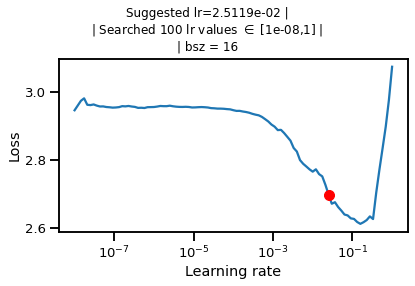

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

In [18]:
%%time


valid_strategies = ("finetuning_unfreeze_layers_on_plateau",)
# pool_types = ("avg", "avgdrop")#, "avgmax", "max", "avgmaxdrop")

# finetuning_strategy="feature_extractor"
# finetuning_strategy="feature_extractor_+_bn.eval()"

# pool_type='avgdrop'
# pool_type='avgmaxdrop'
pool_type="avg"
dropout_p = 0.3





all_results = {}

for strategy in valid_strategies:

    print(f"BEGINNING STRATEGY: {strategy}")
    overrides = ['model/backbone=resnet50',
                 "data=extant_to_pnas",
                 "trainer.max_epochs=1",
                 "trainer.auto_lr_find=true",
                 "trainer.precision=16",
                 "trainer.gpus=[0]",
                 "trainer.resume_from_checkpoint=null",
                 "data.batch_size=16",
                 "logger.wandb.project=finetuning_on_plateau"]

    config, datamodule = get_config_and_load_data(overrides = overrides,
                                                  task_id=1,
                                                  pool_type=pool_type,
                                                  finetuning_strategy=strategy, #"feature_extractor_+_bn.eval()",
                                                  lr=2e-03,
                                                  dropout_p=dropout_p)#,
#                                                   max_epochs=config.trainer.max_epochs)
    ckpt_paths = os.listdir(os.path.join(config.checkpoint_dir))
    if len(ckpt_paths) and os.path.exists(ckpt_paths[-1]):
        print(f"Found {ckpt_paths[-1]}")
        config.resume_from_checkpoint = ckpt_paths[-1]


    model, results = test_model_freeze_strategy(config, datamodule)
    model.cpu()
    del model

    results['model_config'] = OmegaConf.to_container(config.model, resolve=True)
    results['data_config'] = OmegaConf.to_container(config.data, resolve=True)
    
    ETL.config2yaml(results, os.path.join(config.results_dir, "results.yaml"))
    print(f"[SAVED TRIAL RESULTS] Location: {os.path.join(config.results_dir, 'results.yaml')}")
    pp(results)
    
    all_results[strategy] = results

print(f"ALL FINISHED!!! RESULTS:")
pp(all_results)


ETL.config2yaml(all_results, os.path.join(config.root_dir, "results.yaml"))

In [17]:
test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-p

ConfigAttributeError: Missing key max_epochs
    full_key: max_epochs
    object_type=dict

In [ ]:

ckpt_path = '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/finetuning_unfreeze_layers_on_plateau-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=1.102-val_acc=0.475.ckpt'

## scratch

In [10]:
from lightning_hydra_classifiers.utils.common_utils import *

In [11]:
# subset_counts_df.T.plot(kind='bar', figsize=(16,9), multiple='stack')
import seaborn as sns

sns.set_theme(style="ticks", color_codes=True)
# sns.displot(data=subset_counts_df.T, kind='bar', figsize=(16,9), multiple='stack')

from IPython.display import display


available_palettes = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

for p in available_palettes:
    print(p)
    display(sns.color_palette(p))

datamodule.current_task

data_splits=datamodule.current_task

train_key = ["train"]
sort_by = compute_class_counts(data_splits[train_key[0]].targets,
                               sort_by="count")

subset_counts_df = {}
for subset, values in data_splits.items():
    print(subset)
    values = compute_class_counts(data_splits[subset].targets,
                                  sort_by=sort_by)
    subset_counts_df[subset] = values

subset_counts_df = pd.DataFrame.from_dict(subset_counts_df)

In [200]:
df = subset_counts_df.T.stack().reset_index().rename(columns={0:"counts"})#.set_index("subset")

# df.index.name = "subset"
# df.columns.name = "target"


df

subset_counts_df.T#.unstack("target")

df_like = next(iter(df.groupby("subset")))[1]

totals = df_like[["target", "counts"]].assign(counts=df_like["counts"]*0).set_index("target")

# totals = df_like.set_index("subset").assign(count=df["count"]*0)
previous_totals = totals.copy()

previous_totals.counts + data_subset.set_index("target").counts

totals#.set_index("target")
previous_totals
# data_subset.set_index("target")

#     totals["count"] = previous_totals["count"] + data_subset["count"]

# totals["count"]
# previous_totals["count"] + 
data_subset["count"]

colors

df

df.stack("subset")

# gb = df.reset_index().groupby("subset").unstack()

df = df.reset_index().set_index("target")#, "target"))
# gb = df.unstack(("subset","target"))
df.plot(y="counts", hue="subset", kind="bar", stacked=True)

# gb.columns

gb#.set_index(keys=("subset", "target"))

help(gb.plot)

final_sum = df.groupby("target").agg(sum).sort_values("counts")

final_sum

data = totals.counts / final_sum

totals

# data
final_sum

In [101]:
colors = sns.color_palette("Set2")
i=0

for subset_name, data_subset in df.groupby("subset"):
    print(subset_name)
    
    totals.counts = previous_totals.counts + data_subset.set_index("target").counts
    previous_totals.counts = totals.counts
    
    data = totals.counts / final_sum
#     display(totals)
    bar = sns.barplot(data=totals.reset_index(), y="counts",x="target", label=subset_name, color=colors[i], alpha=0.3)#, kind='bar', palette="tab10_r")
#     bar = sns.barplot(data=totals, y="count",x="target", hue="subset", kind='bar', palette="tab10_r")
    i+=1
plt.legend()

# fig, ax = plt.subplots(1, 1, figsize=(16,9))
# bar = sns.catplot(data=df, x="target", y="count", hue="subset", kind='bar', ax=ax, palette="tab10_r")#, multiple='stack')
# bar = sns.catplot(data=df, x="target", y="count", hue="subset", kind='bar', figsize=(16,9), palette="tab10_r")

# for c in colors:
# data_bar_totals = pd.DataFrame.
# dir(pd.DataFrame)


for subset_name, data_subset in df.groupby("subset"):
    print(subset_name, data_subset)
    bar = sns.barplot(data=data_subset, y="count",x="target", hue="subset", kind='bar', palette="tab10_r")





# cat = sns.catplot(data=df, y="count",x="target", hue="subset", kind='bar', palette="tab10_r", height=5, aspect=3, multiple='stack')
# ax = plt.gca()
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=30, ha="right");





sns.catplot(data=df, multiple='stack',  kind='bar')#, figsize=(16,9), multiple='stack')

# a = df.set_index(df.columns.tolist())
a = df.set_index(["subset", "target"])

a.index

# df.T.index.name


df.index#columns

df.T.reset_index()

df.melt(id_vars=["subset", "target"])

penguins = sns.load_dataset("penguins")
sns.displot(penguins, x="flipper_length_mm")

penguins

# # pd.DataFrame({"labels": [() for subset, values in data_splits.items()})

# data_splits_cat = []

# for subset, values in data_splits.items():
#     print(subset)
#     data_splits_cat.extend([(subset, v) for v in values])
    
    
# data_splits_cat = pd.DataFrame.from_records(data_splits_cat, columns=["subset","target"])

# data_splits_cat



sns.set_palette("Set2")

fig, ax = plot_split_distributions(data_splits=datamodule.current_task,
                                   use_one_axis=True,
                                   hist_kwargs={"alpha":0.4,
                                                "multiple":"fill"})
plt.legend()

display(ax[0])

ax[0].legend()

dir(datamodule)

In [8]:
# overrides = ['model/backbone=efficientnet_b3',"data=extant_to_fossil", "trainer.max_epochs=2", "data.batch_size=16", "trainer.precision=16"]
# overrides = ['model/backbone=resnet50',"data=extant_to_pnas", "trainer.max_epochs=20", "data.batch_size=32", "trainer.precision=16", "trainer.gpus=[7]"]
# config = ETL.load_hydra_config(config_name = "config",
#                               config_path = "/media/data/jacob/GitHub/lightning-hydra-classifiers/configs",
#                               overrides=overrides)

# valid_strategies : Tuple[str] = ("feature_extractor",
#                              "feature_extractor_+_bn.eval()",
#                              "feature_extractor_+_except_bn")
            
######################################

## Evaluate multiple strategies

BEGINNING STRATEGY: feature_extractor


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/initialize.py:98: UserWarning: hydra.experimental.initialize_config_dir() is no longer experimental. Use hydra.initialize_config_dir().
  deprecation_warning(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/compose.py:18: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(
2021-10-18 10:50:16,248 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     set_task(task_id=1)
2021-10-18 10:50:16,251 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
2021-10-18 10:50:16,252 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
2021-10-18 10:50:16,401 lightning_hydra_classifiers.scripts.multitask.train INFO     Instantiating callback <pytorch_lightning.callbacks.early_stopping.EarlySt

Set current model training strategy to: feature_extractor
self.num_classes=19


wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2021-10-18 10:50:20,425 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     [Initiating Stage] lr_tuner
2021-10-18 10:50:20,914 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
38.9 K    Trainable params
23.5 M    Non-trainable params
23.5

self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": feature_extractor
"head_type":           linear
"hidden_size":         None
"lr":                  0.002
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01


Global seed set to 98


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

During: self.training_step
is_training:


{'True': 49, 'False': 0}

requires_grad:


{'True': 0, 'False': 98}

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.055973269045352936,
 'val_acc_epoch': 0.055973269045352936,
 'val_loss': 2.5580384731292725,
 'val_loss_epoch': 2.5580384731292725}
--------------------------------------------------------------------------------


Restoring states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
2021-10-18 10:51:28,708 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Saved best lr value (along w/ batch_size, image_size) to file located at: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/task_1/lr_tuner/hparams.yaml
2021-10-18 10:51:28,712 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INF

_runtime,71
_timestamp,1634568689
_step,6
lr_finder/best/loss,2.63223
lr_finder/best/lr,0.03631
lr_finder/batch_size,32
image_size,512


_runtime,▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁
_step,▁▂▃▅▆▇█
lr_finder/best/loss,▁
lr_finder/best/lr,▁
lr_finder/batch_size,▁
image_size,▁


2021-10-18 10:51:35,115 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     FINISHED: `run_lr_tuner(config)`
2021-10-18 10:51:35,116 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Proceeding with:

2021-10-18 10:51:35,117 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Learning rate = 3.631e-02
2021-10-18 10:51:35,118 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Batch size = 32
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
2021-10-18 10:51:35,124 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": feature_extractor
"head_type":           linear
"hidden_size":         None
"lr":                  0.036307805477010104
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
38.9 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.188    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 98
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pl_bolts/callbacks/data_monitor.py:104: UserWarning: ModuleDataMonitor does not support logging with LoggerCollection. Supported loggers are: TensorBoardLogger, WandbLogger
  rank_zero_warn(


Training: 37it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Metric val_acc improved. New best score: 0.336
Epoch 0, global step 62: val_acc reached 0.33645 (best 0.33645), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=2.540-val_acc=0.336.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Metric val_acc improved by 0.087 >= min_delta = 0.05. New best score: 0.424
Epoch 1, global step 124: val_acc reached 0.42364 (best 0.42364), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=01-val_loss=2.167-val_acc=0.424.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Epoch 2, global step 186: val_acc reached 0.43238 (best 0.43238), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=02-val_loss=1.748-val_acc=0.432.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Epoch 3, global step 248: val_acc was not in top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Epoch 4, global step 310: val_acc reached 0.44332 (best 0.44332), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=04-val_loss=2.468-val_acc=0.443.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Epoch 5, global step 372: val_acc was not in top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Metric val_acc improved by 0.067 >= min_delta = 0.05. New best score: 0.491
Epoch 6, global step 434: val_acc reached 0.49078 (best 0.49078), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=06-val_loss=1.956-val_acc=0.491.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Epoch 7, global step 496: val_acc was not in top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)
val/confusion_matrix/restful-snowflake-1


Epoch 8, global step 558: val_acc reached 0.47410 (best 0.49078), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=08-val_loss=2.080-val_acc=0.474.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/restful-snowflake-1


Epoch 9, global step 620: val_acc reached 0.48993 (best 0.49078), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=09-val_loss=2.481-val_acc=0.490.ckpt" as top 2
Saving latest checkpoint...
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:32: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  rank_zero_deprecation(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
Global seed set to 98
/media/data/conda/jrose3/envs/sequoia/lib/python

Set current model training strategy to: feature_extractor
self.num_classes=19
Best checkpoint saved to: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=06-val_loss=1.956-val_acc=0.491.ckpt


Testing: 0it [00:00, ?it/s]

2021-10-18 11:03:59,820 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

[SAVED TRIAL RESULTS] Location: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/results.yaml


{
    'test_acc': 0.2617359757423401,
    'val_acc': 0.4907832741737366,
    'ckpt_path': '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test
_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/
replicate_1/results/checkpoints/epoch=06-val_loss=1.956-val_acc=0.491.ckpt',
    'model_config': {
        'backbone': {'backbone_name': 'resnet50'},
        'backbone_name': 'resnet50',
        'pretrained': True,
        'num_classes': 19,
        'pool_type': 'avg',
        'head_type': 'linear',
        'hidden_size': None,
        'dropout_p': 0.3,
        'lr': 0.036307805477010104,
        'backbone_lr_mult': 0.1,
        'finetuning_strategy': 'feature_extractor',
        'weight_decay': 0.01,
        'seed': 98
    },
    'data_config': {
        '_target_': 
'lightning_hydra_classifiers.experiments.multitask.datamodules.MultiTaskDataModule',
        'image_size': 512,
        'image_buffer_size': 32,
        'batch_size': 32,
        'num_workers': 4,
        'pin_memory': True,
        'dataset_name': 'Extant-PNAS_to_PNAS',
        'experiment': {
            'source_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments
/July2021-Nov2021/csv_datasets/leavesdb-v1_0',
            'experiment_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experim
ents/July2021-Nov2021/csv_datasets/experimental_datasets',
            'experiment_name': 'Extant-to-PNAS-512-transfer_benchmark',
            'seed': 96857,
            'task_0': {
                'name': 'Extant_Leaves_family_10_512_minus_PNAS_family_100_512',
                'val_split': 0.2,
                'test_split': None
            },
            'task_1': {
                'name': 'PNAS_family_100_512_minus_Extant_Leaves_family_10_512',
                'val_split': 0.2,
                'test_split': None
            }
        }
    }
}

BEGINNING STRATEGY: feature_extractor_+_bn.eval()


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/initialize.py:98: UserWarning: hydra.experimental.initialize_config_dir() is no longer experimental. Use hydra.initialize_config_dir().
  deprecation_warning(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/compose.py:18: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(
2021-10-18 11:04:45,931 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     set_task(task_id=1)
2021-10-18 11:04:45,938 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
2021-10-18 11:04:45,939 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
2021-10-18 11:04:46,081 lightning_hydra_classifiers.scripts.multitask.train INFO     Instantiating callback <pytorch_lightning.callbacks.early_stopping.EarlySt

Set current model training strategy to: feature_extractor_+_bn.eval()
self.num_classes=19


train_acc_step,0.65357
train_loss_step,0.81871
epoch,9
trainer/global_step,621
_runtime,774
_timestamp,1634569469
_step,203
val_acc_step,0.51515
val_loss_step,2.96418
val_acc_epoch,0.48993
val_loss_epoch,2.48073


train_acc_step,▁▆▁▄▆▃▄▅▆▅█▆
train_loss_step,█▅▅▃▂▆▅▅▁▄▃▂
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▂▂▅▂▂▂▆▂▂▂▇▃▃▃▇▃▃▃█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc_step,▃▃▄▁▄▂▃▅▄▇█▄▄▃▆▅▃▅▆▄▅▄▂▆▆▅▄▆█▆▇▅▆▆▆▄▆▃▃▅
val_loss_step,▅▅▃█▄▄▂▅▃▃▁▄▄▄▃▅▆▄▃▇▇▅▅▅▅▃▂▅▄▄▃▆▄▃▂▄▅▄▄▇
val_acc_epoch,▁▅▅▅▆▅█▅▇█
val_loss_epoch,▆▄▁▃▅█▂▅▃▅


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2021-10-18 11:04:52,243 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     [Initiating Stage] lr_tuner
2021-10-18 11:04:52,623 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
38.9 K    Trainable params
23.5 M    Non-trainable params
23.5

self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": feature_extractor_+_bn.eval()
"head_type":           linear
"hidden_size":         None
"lr":                  0.002
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01


Global seed set to 98


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

During: self.training_step
is_training:


{'True': 0, 'False': 49}

requires_grad:


{'True': 0, 'False': 98}

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.07444898784160614,
 'val_acc_epoch': 0.07444898784160614,
 'val_loss': 2.543883800506592,
 'val_loss_epoch': 2.543883800506592}
--------------------------------------------------------------------------------


Restoring states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
2021-10-18 11:05:56,848 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Saved best lr value (along w/ batch_size, image_size) to file located at: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/task_1/lr_tuner/hparams.yaml
2021-10-18 11:05:56,852 lightning_hydra_class

_runtime,67
_timestamp,1634569557
_step,6
lr_finder/best/loss,2.6062
lr_finder/best/lr,0.03631
lr_finder/batch_size,32
image_size,512


_runtime,▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁
_step,▁▂▃▅▆▇█
lr_finder/best/loss,▁
lr_finder/best/lr,▁
lr_finder/batch_size,▁
image_size,▁


2021-10-18 11:06:01,787 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     FINISHED: `run_lr_tuner(config)`
2021-10-18 11:06:01,788 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Proceeding with:

2021-10-18 11:06:01,791 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Learning rate = 3.631e-02
2021-10-18 11:06:01,792 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Batch size = 32
2021-10-18 11:06:01,798 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": feature_extractor_+_bn.eval()
"head_type":           linear
"hidden_size":         None
"lr":                  0.036307805477010104
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
38.9 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.188    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 98
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pl_bolts/callbacks/data_monitor.py:104: UserWarning: ModuleDataMonitor does not support logging with LoggerCollection. Supported loggers are: TensorBoardLogger, WandbLogger
  rank_zero_warn(


Training: 37it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Metric val_acc improved. New best score: 0.388
Epoch 0, global step 62: val_acc reached 0.38761 (best 0.38761), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=1.782-val_acc=0.388.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 1, global step 124: val_acc reached 0.38270 (best 0.38761), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=01-val_loss=2.117-val_acc=0.383.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 2, global step 186: val_acc reached 0.43712 (best 0.43712), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=02-val_loss=1.509-val_acc=0.437.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 3, global step 248: val_acc reached 0.40773 (best 0.43712), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=03-val_loss=1.941-val_acc=0.408.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Metric val_acc improved by 0.107 >= min_delta = 0.05. New best score: 0.495
Epoch 4, global step 310: val_acc reached 0.49473 (best 0.49473), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=04-val_loss=1.585-val_acc=0.495.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 5, global step 372: val_acc reached 0.45669 (best 0.49473), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=05-val_loss=1.931-val_acc=0.457.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 6, global step 434: val_acc reached 0.46350 (best 0.49473), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=06-val_loss=1.765-val_acc=0.463.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 7, global step 496: val_acc was not in top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 8, global step 558: val_acc reached 0.47088 (best 0.49473), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=08-val_loss=1.832-val_acc=0.471.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/glad-plant-2


Epoch 9, global step 620: val_acc was not in top 2
Saving latest checkpoint...
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:32: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  rank_zero_deprecation(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
Global seed set to 98
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/media/data/conda/jrose3/envs/sequoia/lib/pyth

Set current model training strategy to: feature_extractor_+_bn.eval()
self.num_classes=19
Best checkpoint saved to: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=04-val_loss=1.585-val_acc=0.495.ckpt


Testing: 0it [00:00, ?it/s]

2021-10-18 11:18:39,476 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

[SAVED TRIAL RESULTS] Location: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/results.yaml


{
    'test_acc': 0.2662663757801056,
    'val_acc': 0.4947287440299988,
    'ckpt_path': '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test
_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_Tr
ue-pool_avg/replicate_1/results/checkpoints/epoch=04-val_loss=1.585-val_acc=0.495.ckpt',
    'model_config': {
        'backbone': {'backbone_name': 'resnet50'},
        'backbone_name': 'resnet50',
        'pretrained': True,
        'num_classes': 19,
        'pool_type': 'avg',
        'head_type': 'linear',
        'hidden_size': None,
        'dropout_p': 0.3,
        'lr': 0.036307805477010104,
        'backbone_lr_mult': 0.1,
        'finetuning_strategy': 'feature_extractor_+_bn.eval()',
        'weight_decay': 0.01,
        'seed': 98
    },
    'data_config': {
        '_target_': 
'lightning_hydra_classifiers.experiments.multitask.datamodules.MultiTaskDataModule',
        'image_size': 512,
        'image_buffer_size': 32,
        'batch_size': 32,
        'num_workers': 4,
        'pin_memory': True,
        'dataset_name': 'Extant-PNAS_to_PNAS',
        'experiment': {
            'source_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments
/July2021-Nov2021/csv_datasets/leavesdb-v1_0',
            'experiment_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experim
ents/July2021-Nov2021/csv_datasets/experimental_datasets',
            'experiment_name': 'Extant-to-PNAS-512-transfer_benchmark',
            'seed': 96857,
            'task_0': {
                'name': 'Extant_Leaves_family_10_512_minus_PNAS_family_100_512',
                'val_split': 0.2,
                'test_split': None
            },
            'task_1': {
                'name': 'PNAS_family_100_512_minus_Extant_Leaves_family_10_512',
                'val_split': 0.2,
                'test_split': None
            }
        }
    }
}

BEGINNING STRATEGY: feature_extractor_+_except_bn


/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/initialize.py:98: UserWarning: hydra.experimental.initialize_config_dir() is no longer experimental. Use hydra.initialize_config_dir().
  deprecation_warning(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/hydra/experimental/compose.py:18: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(
2021-10-18 11:19:24,925 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     set_task(task_id=1)
2021-10-18 11:19:24,931 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
2021-10-18 11:19:24,933 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
2021-10-18 11:19:25,074 lightning_hydra_classifiers.scripts.multitask.train INFO     Instantiating callback <pytorch_lightning.callbacks.early_stopping.EarlySt

Set current model training strategy to: feature_extractor_+_except_bn
self.num_classes=19


train_acc_step,0.8
train_loss_step,0.63374
epoch,9
trainer/global_step,621
_runtime,786
_timestamp,1634570348
_step,203
val_acc_step,0.56061
val_loss_step,2.10756
val_acc_epoch,0.46277
val_loss_epoch,2.18639


train_acc_step,▁▄▅▃▄▅▅▅█▇▆▇
train_loss_step,█▄▂▅▃▅▂▃▁▂▃▂
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▂▂▅▂▂▂▆▂▂▂▇▃▃▃▇▃▃▃█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc_step,▃▃▄▃▁▁▅▄▃█▇▄▃▅▅▄▃▄█▅▃▃▄▆▄▆▄▄▃▅▆▅▂▅▃▄▃▄▅▅
val_loss_step,▄▃▂▅▇▅▂▇▅▂▁▅▄▄▃█▆▄▁▅▇▅▃▇▇▃▂▇▅▃▂▇▆▃▄▆▆▄▄▆
val_acc_epoch,▁▁▄▃█▆▆▅▇▆
val_loss_epoch,▄▇▁▅▂▅▄▅▄█


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2021-10-18 11:19:30,857 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     [Initiating Stage] lr_tuner
2021-10-18 11:19:31,758 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
84.4 K    Trainable params
23.5 M    Non-trainable params
23.5

self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": feature_extractor_+_except_bn
"head_type":           linear
"hidden_size":         None
"lr":                  0.002
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01


Global seed set to 98


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

During: self.training_step
is_training:


{'True': 49, 'False': 0}

requires_grad:


{'True': 98, 'False': 0}

Restoring states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/lr_find_temp_model.ckpt
2021-10-18 11:20:10,724 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Saved best lr value (along w/ batch_size, image_size) to file located at: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/task_1/lr_tuner/hparams.yaml
2021-10-18 11:20:10,727 lightning_hydra_class

_runtime,42
_timestamp,1634570411
_step,6
lr_finder/best/loss,2.6996
lr_finder/best/lr,0.02512
lr_finder/batch_size,16
image_size,512


_runtime,▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁
_step,▁▂▃▅▆▇█
lr_finder/best/loss,▁
lr_finder/best/lr,▁
lr_finder/batch_size,▁
image_size,▁


2021-10-18 11:20:15,446 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     FINISHED: `run_lr_tuner(config)`
2021-10-18 11:20:15,447 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Proceeding with:

2021-10-18 11:20:15,448 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Learning rate = 2.512e-02
2021-10-18 11:20:15,448 lightning_hydra_classifiers.scripts.pretrain.lr_tuner INFO     Batch size = 16
2021-10-18 11:20:15,455 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1 (None): datamodule.setup(stage=fit)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


self.hparams="backbone":            {'backbone_name': 'resnet50'}
"backbone_lr_mult":    0.1
"backbone_name":       resnet50
"dropout_p":           0.3
"finetuning_strategy": feature_extractor_+_except_bn
"head_type":           linear
"hidden_size":         None
"lr":                  0.025118864315095822
"num_classes":         19
"pool_size":           1
"pool_type":           avg
"pretrained":          True
"seed":                98
"weight_decay":        0.01


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | Sequential       | 23.5 M
1 | criterion               | CrossEntropyLoss | 0     
2 | metrics_train           | MetricCollection | 0     
3 | metrics_train_per_class | MetricCollection | 0     
4 | metrics_val             | MetricCollection | 0     
5 | metrics_val_per_class   | MetricCollection | 0     
6 | metrics_test            | MetricCollection | 0     
7 | metrics_test_per_class  | MetricCollection | 0     
-------------------------------------------------------------
84.4 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.188    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 98
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pl_bolts/callbacks/data_monitor.py:104: UserWarning: ModuleDataMonitor does not support logging with LoggerCollection. Supported loggers are: TensorBoardLogger, WandbLogger
  rank_zero_warn(


Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Metric val_acc improved. New best score: 0.475
Epoch 0, global step 125: val_acc reached 0.47490 (best 0.47490), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=00-val_loss=1.124-val_acc=0.475.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Metric val_acc improved by 0.106 >= min_delta = 0.05. New best score: 0.581
Epoch 1, global step 250: val_acc reached 0.58081 (best 0.58081), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=01-val_loss=0.913-val_acc=0.581.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Epoch 2, global step 375: val_acc reached 0.51311 (best 0.58081), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=02-val_loss=0.989-val_acc=0.513.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Epoch 3, global step 500: val_acc reached 0.59269 (best 0.59269), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=03-val_loss=0.930-val_acc=0.593.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Epoch 4, global step 625: val_acc reached 0.61748 (best 0.61748), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=04-val_loss=0.878-val_acc=0.617.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Epoch 5, global step 750: val_acc reached 0.62468 (best 0.62468), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=05-val_loss=0.899-val_acc=0.625.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Epoch 6, global step 875: val_acc was not in top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Epoch 7, global step 1000: val_acc reached 0.61791 (best 0.62468), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=07-val_loss=0.819-val_acc=0.618.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Metric val_acc improved by 0.055 >= min_delta = 0.05. New best score: 0.636
Epoch 8, global step 1125: val_acc reached 0.63592 (best 0.63592), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=08-val_loss=0.893-val_acc=0.636.ckpt" as top 2


Validating: 0it [00:00, ?it/s]

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/callbacks/wandb_callbacks.py:344: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(w, h))


val/per_class/F1_distributions: metric_data[0].shape=(1,)
val/per_class/Precision_distributions: metric_data[0].shape=(1,)
val/per_class/Recall_distributions: metric_data[0].shape=(1,)


/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/utils/plot_utils.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=figsize)


val/confusion_matrix/royal-forest-3


Epoch 9, global step 1250: val_acc reached 0.63780 (best 0.63780), saving model to "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=09-val_loss=0.910-val_acc=0.638.ckpt" as top 2
Saving latest checkpoint...
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:32: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  rank_zero_deprecation(
/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
Global seed set to 98
/media/data/conda/jrose3/envs/sequo

Set current model training strategy to: feature_extractor_+_except_bn
self.num_classes=19
Best checkpoint saved to: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/checkpoints/epoch=09-val_loss=0.910-val_acc=0.638.ckpt


Testing: 0it [00:00, ?it/s]

2021-10-18 11:39:42,636 lightning_hydra_classifiers.experiments.multitask.datamodules INFO     Task_1: datamodule.setup(stage=test)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

[SAVED TRIAL RESULTS] Location: /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_True-pool_avg/replicate_1/results/results.yaml


{
    'test_acc': 0.3675265908241272,
    'val_acc': 0.6377972364425659,
    'ckpt_path': '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test
_logs/avg/feature_extractor_+_except_bn-PNAS-19_classes-res_512-bsz_16-resnet50-pretrained_Tr
ue-pool_avg/replicate_1/results/checkpoints/epoch=09-val_loss=0.910-val_acc=0.638.ckpt',
    'model_config': {
        'backbone': {'backbone_name': 'resnet50'},
        'backbone_name': 'resnet50',
        'pretrained': True,
        'num_classes': 19,
        'pool_type': 'avg',
        'head_type': 'linear',
        'hidden_size': None,
        'dropout_p': 0.3,
        'lr': 0.025118864315095822,
        'backbone_lr_mult': 0.1,
        'finetuning_strategy': 'feature_extractor_+_except_bn',
        'weight_decay': 0.01,
        'seed': 98
    },
    'data_config': {
        '_target_': 
'lightning_hydra_classifiers.experiments.multitask.datamodules.MultiTaskDataModule',
        'image_size': 512,
        'image_buffer_size': 32,
        'batch_size': 16,
        'num_workers': 4,
        'pin_memory': True,
        'dataset_name': 'Extant-PNAS_to_PNAS',
        'experiment': {
            'source_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments
/July2021-Nov2021/csv_datasets/leavesdb-v1_0',
            'experiment_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experim
ents/July2021-Nov2021/csv_datasets/experimental_datasets',
            'experiment_name': 'Extant-to-PNAS-512-transfer_benchmark',
            'seed': 96857,
            'task_0': {
                'name': 'Extant_Leaves_family_10_512_minus_PNAS_family_100_512',
                'val_split': 0.2,
                'test_split': None
            },
            'task_1': {
                'name': 'PNAS_family_100_512_minus_Extant_Leaves_family_10_512',
                'val_split': 0.2,
                'test_split': None
            }
        }
    }
}

ALL FINISHED!!! RESULTS:


{
    'feature_extractor': {
        'test_acc': 0.2617359757423401,
        'val_acc': 0.4907832741737366,
        'ckpt_path': '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_
test_logs/avg/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_
avg/replicate_1/results/checkpoints/epoch=06-val_loss=1.956-val_acc=0.491.ckpt',
        'model_config': {
            'backbone': {'backbone_name': 'resnet50'},
            'backbone_name': 'resnet50',
            'pretrained': True,
            'num_classes': 19,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': None,
            'dropout_p': 0.3,
            'lr': 0.036307805477010104,
            'backbone_lr_mult': 0.1,
            'finetuning_strategy': 'feature_extractor',
            'weight_decay': 0.01,
            'seed': 98
        },
        'data_config': {
            '_target_': 
'lightning_hydra_classifiers.experiments.multitask.datamodules.MultiTaskDataModule',
            'image_size': 512,
            'image_buffer_size': 32,
            'batch_size': 32,
            'num_workers': 4,
            'pin_memory': True,
            'dataset_name': 'Extant-PNAS_to_PNAS',
            'experiment': {
                'source_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experim
ents/July2021-Nov2021/csv_datasets/leavesdb-v1_0',
                'experiment_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/exp
eriments/July2021-Nov2021/csv_datasets/experimental_datasets',
                'experiment_name': 'Extant-to-PNAS-512-transfer_benchmark',
                'seed': 96857,
                'task_0': {
                    'name': 'Extant_Leaves_family_10_512_minus_PNAS_family_100_512',
                    'val_split': 0.2,
                    'test_split': None
                },
                'task_1': {
                    'name': 'PNAS_family_100_512_minus_Extant_Leaves_family_10_512',
                    'val_split': 0.2,
                    'test_split': None
                }
            }
        }
    },
    'feature_extractor_+_bn.eval()': {
        'test_acc': 0.2662663757801056,
        'val_acc': 0.4947287440299988,
        'ckpt_path': '/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_
test_logs/avg/feature_extractor_+_bn.eval()-PNAS-19_classes-res_512-bsz_32-resnet50-pretraine
d_True-pool_avg/replicate_1/results/checkpoints/epoch=04-val_loss=1.585-val_acc=0.495.ckpt',
        'model_config': {
            'backbone': {'backbone_name': 'resnet50'},
            'backbone_name': 'resnet50',
            'pretrained': True,
            'num_classes': 19,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': None,
            'dropout_p': 0.3,
            'lr': 0.036307805477010104,
            'backbone_lr_mult': 0.1,
            'finetuning_strategy': 'feature_extractor_+_bn.eval()',
            'weight_decay': 0.01,
            'seed': 98
        },
        'data_config': {
            '_target_': 
'lightning_hydra_classifiers.experiments.multitask.datamodules.MultiTaskDataModule',
            'image_size': 512,
            'image_buffer_size': 32,
            'batch_size': 32,
            'num_workers': 4,
            'pin_memory': True,
            'dataset_name': 'Extant-PNAS_to_PNAS',
            'experiment': {
                'source_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experim
ents/July2021-Nov2021/csv_datasets/leavesdb-v1_0',
                'experiment_root_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/exp
eriments/July2021-Nov2021/csv_datasets/experimental_datasets',
                'experiment_name': 'Extant-to-PNAS-512-transfer_benchmark',
                'seed': 96857,
                'task_0': {
                    'name': 'Extant_Leaves_family_10_512_minus_PNAS_family_100_512',
                    'val_split': 0.2,
               

CPU times: user 35min 40s, sys: 7min 30s, total: 43min 10s
Wall time: 50min 13s


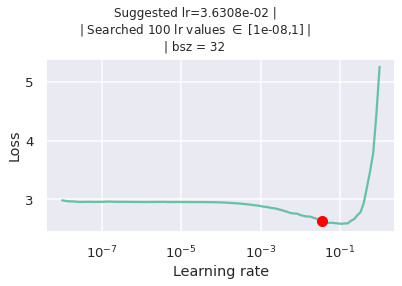

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

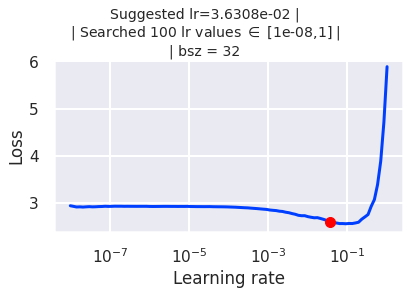

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

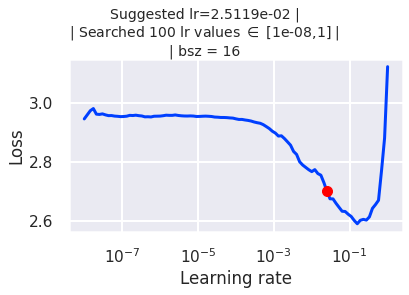

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

<Figure size 792x720 with 0 Axes>

<Figure size 1296x1152 with 0 Axes>

In [10]:
%%time


valid_strategies = ("feature_extractor",
                    "feature_extractor_+_bn.eval()",
                    "feature_extractor_+_except_bn")
pool_types = ("avg", "avgdrop", "avgmax", "max", "avgmaxdrop")

# finetuning_strategy="feature_extractor"
# finetuning_strategy="feature_extractor_+_bn.eval()"

# pool_type='avgdrop'
# pool_type='avgmaxdrop'
pool_type="avg"
dropout_p = 0.3





all_results = {}

for strategy in valid_strategies:

    print(f"BEGINNING STRATEGY: {strategy}")
    overrides = ['model/backbone=resnet50',
                 "data=extant_to_pnas",
                 "trainer.max_epochs=10",
                 "trainer.auto_lr_find=true",
                 "trainer.precision=16",
                 "trainer.gpus=[7]",
                 "trainer.resume_from_checkpoint=null",
                 "logger.wandb.project=bn_global_pool_trials"]
    if strategy in ["feature_extractor_+_except_bn"]:
        overrides.append("data.batch_size=16")
    else:
        overrides.append("data.batch_size=32")


    config, datamodule = get_config_and_load_data(overrides = overrides,
                                                  task_id=1,
                                                  pool_type=pool_type,
                                                  finetuning_strategy=strategy, #"feature_extractor_+_bn.eval()",
                                                  lr=2e-03,
                                                  dropout_p=dropout_p)#,
#                                                   max_epochs=config.trainer.max_epochs)
    ckpt_paths = os.listdir(os.path.join(config.checkpoint_dir))
    if len(ckpt_paths) and os.path.exists(ckpt_paths[-1]):
        print(f"Found {ckpt_paths[-1]}")
        config.resume_from_checkpoint = ckpt_paths[-1]


    model, results = test_model_freeze_strategy(config, datamodule)
    model.cpu()
    del model

    results['model_config'] = OmegaConf.to_container(config.model, resolve=True)
    results['data_config'] = OmegaConf.to_container(config.data, resolve=True)
    
    ETL.config2yaml(results, os.path.join(config.results_dir, "results.yaml"))
    print(f"[SAVED TRIAL RESULTS] Location: {os.path.join(config.results_dir, 'results.yaml')}")
    pp(results)
    
    all_results[strategy] = results

print(f"ALL FINISHED!!! RESULTS:")
pp(all_results)


ETL.config2yaml(all_results, os.path.join(config.root_dir, "results.yaml"))

### plot strategy results

,strategy,val_acc,test_acc
0,feature_extractor,0.490783,0.261736
1,feature_extractor_+_bn.eval(),0.494729,0.266266
2,feature_extractor_+_except_bn,0.637797,0.367527


<Figure size 720x720 with 0 Axes>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

Text(0.5, 0, 'finetuning strategy')

Text(0, 0.5, 'Macro avg acc')

([<matplotlib.axis.XTick at 0x7fa8f09c0d00>,
 [Text(0, 0, 'feature_extractor'),
  Text(0, 0, 'feature_extractor_+_bn.eval()'),
  Text(0, 0, 'feature_extractor_+_except_bn')])

Text(0.5, 0.98, 'resnet50 with global_pool=avg.\n Classifier head trained on PNAS for <=10 epochs')

Final results saved to /media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/bn_unit_test_logs/avg/final_results_plot.png


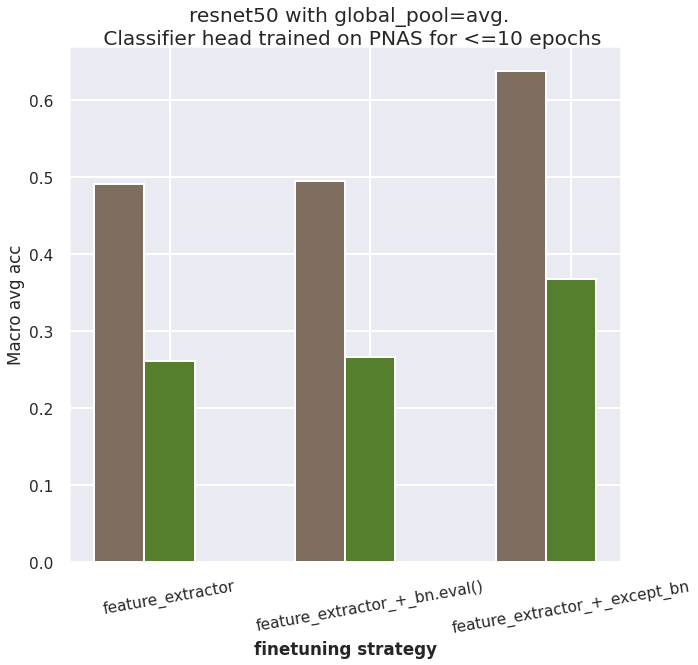

In [11]:
strategies_x = []
val_accs = []
test_accs = []
for k,v in all_results.items():
    strategies_x.append(k)
    try:
        val_accs.append(v['val_acc'])
        test_accs.append(v['test_acc'])
    except:
        val_accs.append(v['val'])
        test_accs.append(v['test'])
        
        
        
import matplotlib.pyplot as plt
import seaborn as sns


results_df = pd.DataFrame({"strategy":strategies_x,
                           "val_acc":val_accs,
                           "test_acc":test_accs})
results_df

barWidth = 0.25

r1 = np.arange(len(strategies_x))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(10,10))

plt.bar(r1, val_accs, color='#7f6d5f', width=barWidth, edgecolor='white', label='val')
plt.bar(r2, test_accs, color='#557f2d', width=barWidth, edgecolor='white', label='test')

 
# Add xticks on the middle of the group bars
plt.xlabel('finetuning strategy', fontweight='bold')
plt.ylabel("Macro avg acc")
plt.xticks([r + barWidth for r in range(len(strategies_x))], strategies_x, rotation=10)
plt.suptitle(f"{config.model.backbone_name} with global_pool={config.model.pool_type}." + "\n Classifier head trained on PNAS for <=10 epochs")
plt.tight_layout(rect=[0.0, 0.05, 1.0, 0.95])
plt.savefig(os.path.join(config.root_dir, "final_results_plot.png"))
print(f"Final results saved to", os.path.join(config.root_dir, "final_results_plot.png"))
# sns.barplot(data=results_df, x='strategy', y='val_acc')

In [ ]:
Next: Add specific tests for different freeze strategies

## Training script development
(10-17-21)

In [ ]:
# source: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html

def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         progress_bar_refresh_rate=1)                                                        # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [8]:
# class LightningClassifier(BaseLightningModule):
#     def __init__(self,
#                  backbone_name='gluon_seresnext50_32x4d',
#                  pretrained: Union[bool, str]=True,
#                  num_classes: int=1000,
#                  pool_size: int=1,
#                  pool_type: str='avg',
#                  head_type: str='linear',
#                  hidden_size: Optional[int]=512,
#                  lr: float=2e-03,
#                  weight_decay: float=0.01,
#                  seed: int=None):
#         super().__init__(seed=seed)
#         self.save_hyperparameters()
        
#         self.model = build_model(backbone_name=backbone_name,
#                                       pretrained=pretrained,
#                                       num_classes=num_classes,
#                                       pool_size=pool_size,
#                                       pool_type=pool_type,
#                                       head_type=head_type,
#                                       hidden_size=hidden_size)
    
#         self.criterion = nn.CrossEntropyLoss()
#         self.metrics = self.init_metrics(stage='all')
    
#     def forward(self,x):
#         return self.model(x)
    
    
#     def get_lr(self, group: str=None):
#         if group is None:
#             return self.hparams.lr
#         if group == "backbone":
#             return self.hparams.lr * 0.1
#         if group == "head":
#             return self.hparams.lr
    
#     def configure_optimizers(self):
#         print(f"self.hparams={self.hparams}")
#         self.optimizer = torch.optim.AdamW([{"params":self.model.backbone.parameters(), "lr":self.get_lr("backbone"), "weight_decay": self.hparams.weight_decay},
#                                             {"params":self.model.head.parameters(), "lr":self.get_lr("head"), "weight_decay": self.hparams.weight_decay}])
# #         self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.config.t_max, eta_min=self.config.min_lr)

#         return {'optimizer': self.optimizer}

In [9]:
# class BnFreeze(Callback):
# source: https://github.com/fastai/fastai/blob/master/fastai/callback/training.py#L55
#     run_after=TrainEvalCallback
#     "Freeze moving average statistics in all non-trainable batchnorm layers."
#     def before_train(self):
#         set_bn_eval(self.model)
        
        
        

# Experiments

For each architecture, 3 different experimental training methods will be evaluated

Training methods:  
1. Feature Extractor  
2. Feature Extractor + set batchnorm to eval()  
3. Freeze backbone except for all batchnorm layers  



Baseline:  
   * Architecture 1. simple pretrained backbone -> `avg_pool` -> linear_classifier  
    
Next Comparisons:  
* Architecture 2. simple pretrained backbone -> `max_pool` -> linear_classifier
* Architecture 3. simple pretrained backbone -> `avgmax_pool` -> linear_classifier  

Later:  
* Architecture 4. simple pretrained backbone -> `avgdrop_pool` -> linear_classifier  
* Architecture 5. simple pretrained backbone -> `maxdrop_pool` -> linear_classifier  
* Architecture 6. simple pretrained backbone -> `avgmaxdrop_pool` -> linear_classifier  

In [10]:
# model = build_model(backbone_name='gluon_seresnext50_32x4d',
#                     pretrained=True,
#                     num_classes=19,
#                     pool_size=1,
#                     pool_type='avgmax',
#                     head_type='linear',
#                     hidden_size=None)
# from torchinfo import summary


#left off here 11 pm

# model = LightningClassifier(backbone_name='gluon_seresnext50_32x4d',
#                             pretrained=True,
#                             num_classes=19,
#                             pool_size=1,
#                             pool_type='avgmax',
#                             head_type='linear',
#                             hidden_size=None,
#                             lr=2e-03,
#                             weight_decay=0.01,
#                             seed=98)

# pp(list(model.get_batchnorm_modules()))
# # pp(list(model.get_conv_modules()))
# pp(list(model.get_linear_modules()))
# # pp(list(model.get_conv_modules()))
# pp(list(model.get_named_modules()))

# model.freeze_backbone(freeze_bn=False)
# model.freeze_backbone(freeze_bn=True)
# summary(model.model)

# print(f"trainable: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable: {len(list(model.get_nontrainable_parameters()))}")

# bn = {n:p.requires_grad for n, p in model.get_named_parameters("bn")}

### Mini test: Wrap all model hooks & display + verify for each parameter group the proper status of module.training & weight_tensors.requires_grad

### 1. feature extractor

In [70]:
model.freeze_backbone(freeze_bn=True) #False)
# model.set_bn_eval()
# summary(model.model)
model.count_trainable_batchnorm_layers()
count_parameters(model.model, verbose=False);

trainable batchnorm modules:49
nontrainable batchnorm modules:0
batchnorm params with requires_grad=True: :0
batchnorm params with requires_grad=False:98
Total Trainable Params: 77,843
Total non-Trainable Params: 25,510,896


### 2. Feature extractor + BN set to Eval()

In [71]:
model.freeze_backbone(freeze_bn=True)
model.set_bn_eval(model)
# summary(model.model)
model.count_trainable_batchnorm_layers()
count_parameters(model.model, verbose=False);

trainable batchnorm modules:0
nontrainable batchnorm modules:49
batchnorm params with requires_grad=True: :0
batchnorm params with requires_grad=False:98
Total Trainable Params: 77,843
Total non-Trainable Params: 25,510,896


### 2. Freeze backbone except for BN layers

In [72]:
# model.unfreeze(model.model)
model.freeze_backbone(freeze_bn=False)

model.unfreeze(model.model,
               filter_pattern="bn")
# summary(model.model)
model.count_trainable_batchnorm_layers()
count_parameters(model.model, verbose=False);

trainable batchnorm modules:49
nontrainable batchnorm modules:0
batchnorm params with requires_grad=True: :98
batchnorm params with requires_grad=False:0
Total Trainable Params: 138,387
Total non-Trainable Params: 25,450,352


## Load data, model, trainer, callbacks, logger

In [11]:
from lightning_hydra_classifiers.scripts.multitask.train import MultiTaskDataModule, LitMultiTaskModule, ImagePredictionLogger, train_task,  CIFAR10DataModule, run_multitask_test, load_data_and_model, load_data, resolve_config, configure_callbacks, configure_loggers, configure_trainer
from lightning_hydra_classifiers.data.datasets.common import toPIL
from lightning_hydra_classifiers.utils.etl_utils import ETL
from omegaconf import OmegaConf


# overrides = ['model/backbone=efficientnet_b3',"data=extant_to_fossil", "trainer.max_epochs=2", "data.batch_size=16", "trainer.precision=16"]
overrides = ['model/backbone=resnet50',"data=extant_to_pnas", "trainer.max_epochs=20", "data.batch_size=32", "trainer.precision=16", "trainer.gpus=[7]"]
config = ETL.load_hydra_config(config_name = "config",
                              config_path = "/media/data/jacob/GitHub/lightning-hydra-classifiers/configs",
                              overrides=overrides)

task_id = 1
pp(config.data)
datamodule = load_data(config,
                       task_id=task_id)


        
# model_config = OmegaConf.create(dict(
#                                 backbone_name=config.model.backbone.backbone_name, #'gluon_seresnext50_32x4d',
#                                 pretrained=True,
#                                 num_classes=datamodule.num_classes,
#                                 pool_type='avg',
#                                 head_type='linear',
#                                 hidden_size=None,
#                                 lr=2e-03,
#                                 weight_decay=0.01,
#                                 seed=98))

# model_config = OmegaConf.create(dict(
#                                 backbone_name=config.model.backbone.backbone_name, #'gluon_seresnext50_32x4d',
#                                 pretrained=True,
#                                 num_classes=datamodule.num_classes,
#                                 pool_type='max',
#                                 head_type='linear',
#                                 hidden_size=None,
#                                 lr=2e-03,
#                                 weight_decay=0.01,
#                                 seed=98))

model_config = OmegaConf.create(dict(
                                backbone_name=config.model.backbone.backbone_name, #'gluon_seresnext50_32x4d',
                                pretrained=True,
                                num_classes=datamodule.num_classes,
                                pool_type='avgdrop',
                                head_type='linear',
                                hidden_size=None,
                                lr=2e-03,
                                backbone_lr_mult=0.1,
                                finetuning_strategy="feature_extractor",
                                weight_decay=0.01,
                                seed=98))



config.model = model_config

algorithm_name = "feature_extractor"
config.experiment_name = f"{algorithm_name}-PNAS-{datamodule.num_classes}_classes-res_{config.data.image_size}-bsz_{config.data.batch_size}-{config.model.backbone_name}-pretrained_{config.model.pretrained}-pool_{config.model.pool_type}"


experiment_dir = config.experiment_dir
results_dir = config.results_dir
results_dir

model = LightningClassifier(**config.model)
model.label_encoder = datamodule.label_encoder


group = f'{config.model.backbone_name}__PNAS__experiment_0__feature_extractor'
config.logger.wandb.group = group
config.callbacks.log_per_class_metrics_to_wandb.class_names = datamodule.classes


callbacks = configure_callbacks(config)
logger = configure_loggers(config)

trainer: pl.Trainer = configure_trainer(config, callbacks=callbacks, logger=logger)

## Run lr_tune->fit->test

In [17]:
from lightning_hydra_classifiers.scripts.pretrain import lr_tuner


lr_tuner_results_dir = os.path.join(results_dir, f"task_{task_id}", "lr_tuner")
lr_tune_output = lr_tuner.run_lr_tuner(trainer=trainer,
                                       model=model,
                                       datamodule=datamodule,
                                       config=config,
                                       results_dir=lr_tuner_results_dir,
                                       group=group)

## model.fit

hist = trainer.fit(model, datamodule=datamodule)

## model.test

test_result = trainer.test()

# Other

In [17]:
import os
import pandas as pd 
import numpy as np
import logging
from sklearn.metrics import classification_report, f1_score

In [143]:
classification_report


# def predict_step(batch, batch_idx=None):
#     out = self.step(batch, batch_idx)
#     if hasattr(batch, "metadata"):
#         if "path" in batch.metadata:
#             out = [*out, batch.metadata["path"]]
#     return out

# self=model
# model.predict_step = predict_step
# test_results = trainer.predict(dataloaders=datamodule.test_dataloader(), return_predictions=True)
# results = collect_results(prediction_results)
prediction_results = test_results
results = collect_results(prediction_results)
len(prediction_results[0])
# len(results)

def tensors2np(t: Union[torch.Tensor, list]) -> np.ndarray:
    if isinstance(t, torch.Tensor):
        t = t.cpu().numpy()
    elif isinstance(t, list):
        t = list(map(tensors2np, t))
    if isinstance(t, np.ndarray):
        return t
    else:
        raise TypeError(f"type(t)={type(t)} is invalid for function tensors2np" + '\n' + 'tensors2np(t: Union[torch.Tensor, list]) -> np.ndarray:')
        
rows = []
for result in list(prediction_results):
    
    y_logit.append(result[0])
    y_true.append(result[1])
    y_pred.append(result[2])
    paths.extend(result[3])
    
y_logit = torch.cat(y_logit).cpu().numpy()
y_true = torch.cat(y_true).cpu().numpy()
y_pred = torch.cat(y_pred).cpu().numpy()
# paths = torch.cat(paths).cpu().numpy()

# [(r[0].device, r[0].shape, r[1].shape, r[2].shape) for r in test_results]

print(y_logit.shape, y_true.shape, y_pred.shape, len(paths))

In [ ]:
label_encoder = model.label_encoder




In [208]:
from torch.functional import F



# https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwji_bKG6cPzAhXJT98KHU0eCsg4HhAWegQIAhAB&url=https%3A%2F%2Fclear.ml%2Fdocs%2Flatest%2Fdocs%2Fguides%2Freporting%2Fexplicit_reporting%2F&usg=AOvVaw3tvUYT7fU3QHIwunDpE800
labels = model.label_encoder.classes

test_predictions_filepath = os.path.join(results_dir, f"task_{task_id}", "test_predictions.csv")


class ImageInterpretation:
    
    def __init__(self, model, datamodule, trainer, y_col: str='family'):
        self.model = model
        self.dm = datamodule
        self.trainer = trainer
        self.y_col = y_col

        
    @property
    def decoder(self):
        return self.dm.label_encoder.idx2class
        
    def decode_label(y: int): #, labels: Union[Dict[int, str], List[str]]=None):
        try:
            return self.decoder[y]
        except:
            return y
        
    def log_image_predictions(self,
                              results_path: str=None,
                              sort_by_losses: bool=True,
                              ascending: bool=True) -> pd.DataFrame:
        """
        Save table of model predictions as csv
        
        |losses	|y_true	|y_pred	|paths 	|per-class logits|
        |---	|---	|---	|---	| ---	 |---	 |
        |   	|   	|   	|   	|   	 |   	 |
        |   	|   	|   	|   	|   	 |   	 |
        
        
        """

        pred_results = trainer.predict(dataloaders=datamodule.test_dataloader(), return_predictions=True)

        results = collect_results(pred_results)

        labels = list(self.decoder.values())
        columns = ["xEnt_loss", f"{self.y_col}_true", f"{self.y_col}_pred", "paths", *[f"{l}_logit" for l in labels]]

        y_logits = torch.from_numpy(results[0].astype("float32"))
        y_true = torch.from_numpy(results[1])
        xEnt_loss = F.cross_entropy(y_logits, y_true, reduction="none")

        losses = xEnt_loss
        y_true = results[1]
        y_pred = results[2]
        paths = results[3]
        per_class_y_logits = np.hsplit(results[0], results[0].shape[1])

        num_results = len(results[0])
        rows = []
        for i in range(num_results):
            rows.append({k:v for k, v in zip(columns,
                                             [losses,
                                              self.decode_label(y=y_true[i]),
                                              self.decode_label(y=y_pred[i]),
                                              paths[i],
                                              *(y[i].item() for y in per_class_y_logits)]
                                            )
                        })

        data_df = pd.DataFrame.from_records(rows)
        
        if sort_by_losses:
            data_df = data_df.sort_values("xEnt_loss", ascending=ascending)
        
        ETL.df2csv(data_df, results_spath)
        
        return data_df

        
        

#         data = {"xEnt_loss":xEnt_loss,
#                 f"{self.y_col}_true":results[1],
#                 f"{self.y_col}_pred":results[2],
#                 "path":results[3],
#                 "y_logits":np.hsplit(results[0], results[0].shape[1])}    
    
    
    
#         rows = []
#         for i in range(num_results):
#             rows.append({k:v for k, v in zip(columns,
#                                              [data["xEnt_loss"][i], 
#                                               self.decode_label(y=data[f"{self.y_col}_true"][i]),
#                                               self.decode_label(y=data[f"{self.y_col}_pred"][i]),
#                                               data["path"][i],
#                                               *(y[i].item() for y in data["y_logits"])]
#                                             )
#                         })

#         data_df = pd.DataFrame.from_records(rows)
#         ETL.df2csv(data_df, test_predictions_filepath)



In [230]:
data_df.sort_values("Anacardiaceae_logit")

,family_true,family_pred,paths,Anacardiaceae_logit,Annonaceae_logit,Apocynaceae_logit,Betulaceae_logit,Celastraceae_logit,Combretaceae_logit,Ericaceae_logit,Fabaceae_logit,Fagaceae_logit,Lauraceae_logit,Malvaceae_logit,Melastomataceae_logit,Myrtaceae_logit,Passifloraceae_logit,Phyllanthaceae_logit,Rosaceae_logit,Rubiaceae_logit,Salicaceae_logit,Sapindaceae_logit
2382,3,3,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Betulaceae/Betulaceae_Corylus_sieboldiana_Wolfe_8505.jpg,-3.701172,-1.307617,-3.009766,6.000000,-3.759766,-5.464844,-3.427734,-3.501953,2.558594,-2.662109,-0.223267,-5.761719,-5.398438,-5.808594,-5.355469,4.937500,0.086670,-2.923828,2.140625
2379,3,3,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Betulaceae/Betulaceae_Carpinus_minutiserrata_Wolfe_8499.jpg,-3.636719,-0.404541,-3.140625,6.570312,-3.857422,-5.554688,-2.789062,-3.111328,2.324219,-1.705078,-0.510254,-4.355469,-4.910156,-6.250000,-5.363281,4.960938,-1.021484,-3.556641,1.875000
1310,17,17,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Salicaceae/Salicaceae_Salix_paradoxa_Wolfe_18143.jpg,-3.542969,-0.666504,-0.868652,-4.914062,-1.795898,-0.714355,-3.437500,-1.461914,-1.703125,-0.938477,-1.060547,-4.484375,-1.119141,-2.339844,-0.384521,-2.453125,-0.583984,0.764648,-2.248047
2220,11,16,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Melastomataceae/Melastomataceae_Miconia_candolleana_Wolfe_7579.jpg,-3.531250,-1.310547,0.375000,-3.238281,-1.906250,-0.319824,-2.828125,-0.099548,-1.003906,-1.366211,-2.339844,-2.994141,-0.514160,-2.351562,-1.755859,-1.009766,0.995605,-0.788086,-1.653320
2388,3,3,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Betulaceae/Betulaceae_Betula_delavayi_Wolfe_8515.jpg,-3.523438,-1.132812,-2.919922,5.539062,-3.652344,-5.593750,-3.361328,-3.464844,2.539062,-2.875000,-0.327637,-5.246094,-4.781250,-5.527344,-5.289062,4.582031,0.183960,-2.988281,2.130859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,0,1,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Anacardiaceae/Anacardiaceae_Anacardium_microsepalum_Wolfe_4202.jpg,2.031250,2.220703,0.378418,-1.996094,-2.458984,-5.179688,-1.397461,-1.719727,-1.301758,-0.013664,-3.351562,-2.388672,-0.104553,-4.355469,-3.957031,-1.269531,-0.753418,-3.931641,0.276123
2503,2,0,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Apocynaceae/Apocynaceae_Condylocarpon_amazonicum_Wolfe_9166.jpg,2.072266,1.169922,0.980957,-1.467773,-2.337891,-5.261719,-1.712891,-1.980469,-1.117188,-1.140625,-3.160156,-1.918945,0.444092,-3.927734,-4.417969,-1.185547,-0.756348,-3.855469,0.513184
703,0,1,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Anacardiaceae/Anacardiaceae_Anacardium_humile_Wolfe_12854.jpg,2.318359,2.531250,0.029694,-2.062500,-2.750000,-4.988281,-1.211914,-1.269531,-1.435547,-0.288818,-3.263672,-1.830078,-0.763672,-4.531250,-3.882812,-1.215820,-0.182251,-4.171875,-0.325928
2281,1,0,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Annonaceae/Annonaceae_Cyathocalyx_pahangensis_Wolfe_7860.jpg,2.400391,1.263672,0.446533,-1.714844,-2.597656,-5.339844,-1.846680,-1.754883,-1.322266,-0.888672,-2.570312,-2.365234,-0.152954,-3.791016,-4.105469,-1.630859,-0.832520,-3.966797,0.582031


In [209]:
data_df
test_predictions_filepath

,family_true,family_pred,paths,Anacardiaceae_logit,Annonaceae_logit,Apocynaceae_logit,Betulaceae_logit,Celastraceae_logit,Combretaceae_logit,Ericaceae_logit,Fabaceae_logit,Fagaceae_logit,Lauraceae_logit,Malvaceae_logit,Melastomataceae_logit,Myrtaceae_logit,Passifloraceae_logit,Phyllanthaceae_logit,Rosaceae_logit,Rubiaceae_logit,Salicaceae_logit,Sapindaceae_logit
0,8,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Fagaceae/Fagaceae_Lithocarpus_densiflora_Axelrod_105.jpg,-2.101562,0.946777,-2.197266,-5.257812,-1.637695,-4.351562,-0.747070,2.486328,-2.169922,1.900391,-2.886719,-4.980469,-2.761719,-3.220703,-2.039062,-2.855469,-1.358398,-2.119141,-1.598633
1,6,17,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Ericaceae/Ericaceae_Arctostaphylos_bicolor_Axelrod_1064.jpg,-1.948242,-0.208008,-1.406250,-2.642578,-0.841797,-3.482422,-1.020508,-0.872070,-1.964844,-1.522461,-0.915039,-5.437500,-3.214844,-2.896484,-1.683594,0.409424,-1.733398,1.350586,-0.226807
2,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Fabaceae/Fabaceae_Amorpha_californica_Axelrod_107.jpg,-1.899414,0.320557,-1.014648,-2.306641,-0.415283,-2.873047,0.164185,0.775391,-1.668945,-0.221802,-1.568359,-3.824219,-2.728516,-2.455078,-2.048828,0.622559,-1.046875,0.237793,-0.510742
3,0,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Anacardiaceae/Anacardiaceae_Rhus_scheidana_Axelrod_1083.jpg,-2.119141,0.247192,-0.884277,-3.435547,-0.860840,-2.496094,-0.708984,0.709961,-1.564453,-0.077454,-1.122070,-3.429688,-2.224609,-2.107422,-1.483398,-0.923340,-1.385742,0.063416,-0.836426
4,15,18,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Rosaceae/Rosaceae_Holodiscus_bousierii_Axelrod_11.jpg,-1.210938,-0.155151,-0.820312,-0.239014,-1.089844,-3.675781,-0.708984,-0.143677,-0.320557,-1.643555,-1.702148,-4.644531,-3.546875,-4.359375,-3.392578,1.975586,0.340088,-1.000000,2.621094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Fabaceae/Fabaceae_Spatholobus_sanguineus_Wolfe_9986.jpg,-1.414062,-0.408203,-1.287109,-1.636719,-1.176758,-3.201172,-1.117188,0.658691,-0.553223,-0.359619,-0.608398,-4.261719,-3.195312,-2.927734,-2.158203,-0.062805,-0.152954,-1.143555,0.043213
2793,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Fabaceae/Fabaceae_Strongylodon_lucidus_Wolfe_9991.jpg,-1.657227,-0.341553,-1.412109,-2.822266,-1.095703,-2.773438,-0.649414,1.941406,-1.231445,-0.438477,-1.717773,-4.644531,-3.406250,-3.111328,-2.568359,-0.196289,-0.147827,-1.016602,-0.682617
2794,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/test/Fabaceae/Fabaceae_Sweetia_nitens_Wolfe_9994.jpg,-1.159180,0.910645,-1.306641,-3.710938,-1.150391,-4.042969,-0.448486,0.985352,-1.852539,0.742188,-2.884766,-3.646484,-1.609375,-2.974609,-2.533203,-1.801758,-1.070312,-1.525391,-0.565918
2795,7,7,/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512/train/Fabaceae/Fabaceae_Templetonia_retusa_Wolfe_9995.jpg,-1.577148,-1.782227,-1.040039,-3.068359,-2.150391,-1.496094,-1.236328,3.931641,-1.172852,-2.310547,-3.220703,-5.195312,-2.341797,-3.683594,-3.480469,-0.072754,0.024765,-1.898438,-1.231445


'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/experiment_logs/Transfer_Experiments/feature_extractor-PNAS-19_classes-res_512-bsz_32-resnet50-pretrained_True-pool_avg/replicate_1/results/task_1/test_predictions.csv'

## generate report

In [52]:
from lightning_hydra_classifiers.utils.report_utils.pandas_embed_images import df_embed_paths2imgs



df_embed_paths2imgs(df: pd.DataFrame,
                        file_path: str, 
                        path_col: str="path",
                        display: bool=False

fastprogress                   1.0.0


In [50]:
len(paths)

y_logit#.shape

2797

array([[-2.102e+00,  9.468e-01, -2.197e+00, ..., -1.358e+00, -2.119e+00,
        -1.599e+00],
       [-1.948e+00, -2.080e-01, -1.406e+00, ..., -1.733e+00,  1.351e+00,
        -2.268e-01],
       [-1.899e+00,  3.206e-01, -1.015e+00, ..., -1.047e+00,  2.378e-01,
        -5.107e-01],
       ...,
       [-1.159e+00,  9.106e-01, -1.307e+00, ..., -1.070e+00, -1.525e+00,
        -5.659e-01],
       [-1.577e+00, -1.782e+00, -1.040e+00, ...,  2.477e-02, -1.898e+00,
        -1.231e+00],
       [-9.277e-01, -4.192e-01, -9.902e-01, ..., -2.041e-03, -2.395e+00,
        -2.004e+00]], dtype=float16)

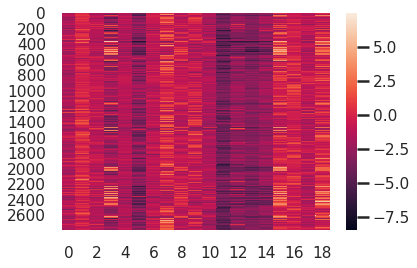

In [51]:
import seaborn as sns

sns.heatmap(y_logit)

In [ ]:
# logger = logging.getLogger(__name__)

def generate_report(y_pred,
                    y_true, 
                    labels=None,
                    results_dir: str=None):
    """Create a performance report for the current experiment and 
    consolidate the information to a general report of all runs 
    Parameters
    ----------
    opt : sklearn.model_selection.Object
        A hyperparameter 
    X_test: numpy array or pandas Dataframe 
        Input test data
    y_test: numpy array or pandas Dataframe 
        Target test data
    """


    logger.info("Generating Evaluation Report:")
    

    res = classification_report(y_true, y_pred, labels=labels, output_dict=True)
    res = pd.DataFrame(res)

    logger.info("Test report:")
    logger.info('\n \t'+ res.to_string().replace('\n', '\n\t'))
    
    f1 = f1_score(y_true, y_pred, labels=labels, average='macro')
    
    steps= [*pipeline.named_steps]

    cv_mean ,cv_std = opt.best_score_,opt.cv_results_['std_test_score'][opt.best_index_]

    tmp= pd.DataFrame({"Scaling":[steps[0]],
                        "Model":[steps[1]],
                        "params":[opt.best_params_],
                        'CV Mean':[cv_mean],
                        'CV Std':[cv_std],
                        'Test dataset':f1,
                        })

    if os.path.exists(path+"/results.csv"):
        current_csv =pd.read_csv(path+"/results.csv")
        pd.concat([current_csv, tmp], 
                   ignore_index=True
                 ).to_csv(path+"/results.csv",
                          index=False)    
    else:
        tmp.to_csv(path+"/results.csv",
                   index=False)

In [ ]:


model = LightningClassifier(backbone_name='gluon_seresnext50_32x4d',
                            pretrained=True,
                            num_classes=19,
                            pool_size=1,
                            pool_type='avgmax',
                            head_type='linear',
                            hidden_size=None,
                            lr=2e-03,
                            weight_decay=0.01,
                            seed=98)

In [20]:
# import bqplot.pyplot as plt
# from dataclasses import dataclass
# @dataclass
# class LRTunerConfig:
    
#     min_lr: float = 1e-08
#     max_lr: float = 1.0
#     num_training: int = 50
#     mode: str = 'exponential'
#     early_stop_threshold: float = 4.0

# cfg = OmegaConf.structured(LRTunerConfig())

# lr_tuner = trainer.tuner.lr_find(model,
#                                  data,
#                                  **cfg)
# lr_tuner_results = lr_tuner.results
# best_lr = lr_tuner.suggestion()

# suggestion = {"lr": best_lr,
#               "loss":lr_tuner_results['loss'][lr_tuner._optimal_idx]}

# plt.figure()
# fig = lr_tuner.plot(suggest=True)
# lr_tuner_results_dir = os.path.join(results_dir, f"task_{task_id}", "lr_tuner")

# plot_fname = 'lr_tuner_results_loss-vs-lr.png'
# plot_path = Path(lr_tuner_results_dir) / plot_fname
# plt.title(f"Suggested lr={best_lr:.4e} |\n| Searched {lr_tuner.num_training} lr values $\in$ [{lr_tuner.lr_min},{lr_tuner.lr_max}] |\n| bsz = {config.data.batch_size}", style={"fontsize":'small'})
# fig.save_png(filename=str(plot_path))

# fig = plt.figure()
# plt.plot(x=lr_tuner.results['lr'],
#          y=lr_tuner.results['loss'],
#         figure=fig)

## Display available global pool types

### Aside: Verify task_0 and task_1 label maps all agree

In [8]:
task_0_labels = data.label_encoder

data.setup(stage='fit', task_id=1)

task_1_labels = data.label_encoder

task_0_labels
task_1_labels

task_0_labels
print(f"label|task_0_idx|task_1_idx")
for label, idx in task_1_labels.class2idx.items():
    print(f"{label}|{task_0_labels.class2idx[label]}|{idx}")
    
    assert task_0_labels.class2idx[label] == idx
    
print(f"Success, all labels in task_1 have identical integer mappings to their corresponding values in task_0")

In [23]:
class2idx = data.label_encoder.class2idx
family_counts = df.value_counts("family").to_dict()

df = df.assign(class_idx=df.family.apply(lambda x: class2idx[x]),
               score = df.family.apply(lambda x: family_counts[x]))

df#.clear_intent()

df.groupby('class_idx').mean()

# df.exported.keys()

df.exported['Distribution']

df.compute_metadata()

df

df.clear_intent()

In [20]:
backbone_name='gluon_seresnext50_32x4d'
pretrained=True
num_classes=1000

head_type='linear'
hidden_size=0

pool_types = ["avg", "max", "avgmax"]

models = OrderedDict({})

for pool_type in pool_types:
    models[pool_type] = build_model(backbone_name=backbone_name,
                                    pretrained=pretrained,
                                    num_classes=num_classes,
                                    pool_size=1,
                                    pool_type=pool_type,
                                    head_type=head_type,
                                    hidden_size=hidden_size)
print(f"backbone={backbone_name}|pretrained={pretrained}|num_classes={num_classes}|head_type={head_type}|hidden_size={hidden_size}")
for pool_type, model in models.items():
    print(f"pool_type={pool_type}")
    pp({k: v.shape for k,v in model.head.named_parameters()})
#     pp(list(dict(model.head.named_parameters()).keys()))

dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
backbone=gluon_seresnext50_32x4d|pretrained=True|num_classes=1000|head_type=linear|hidden_size=0
pool_type=avg


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=max


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=avgmax


{'classifier.weight': torch.Size([1000, 8192]), 'classifier.bias': torch.Size([1000])}

## Display available head types (TBD)

In [20]:
backbone_name='gluon_seresnext50_32x4d'
pretrained=True
num_classes=1000

head_types=['linear', 'custom']
hidden_size=0

pool_types = ["avg", "max", "avgmax"]

models = OrderedDict({})

for pool_type in pool_types:
    models[pool_type] = build_model(backbone_name=backbone_name,
                                    pretrained=pretrained,
                                    num_classes=num_classes,
                                    pool_size=1,
                                    pool_type=pool_type,
                                    head_type=head_type,
                                    hidden_size=hidden_size)
print(f"backbone={backbone_name}|pretrained={pretrained}|num_classes={num_classes}|head_type={head_type}|hidden_size={hidden_size}")
for pool_type, model in models.items():
    print(f"pool_type={pool_type}")
    pp({k: v.shape for k,v in model.head.named_parameters()})
#     pp(list(dict(model.head.named_parameters()).keys()))

dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
dict_keys(['backbone_name', 'pretrained', 'num_classes', 'pool_size', 'pool_type', 'head_type', 'hidden_size', 'backbone', 'feature_size'])
backbone=gluon_seresnext50_32x4d|pretrained=True|num_classes=1000|head_type=linear|hidden_size=0
pool_type=avg


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=max


{'classifier.weight': torch.Size([1000, 4096]), 'classifier.bias': torch.Size([1000])}

pool_type=avgmax


{'classifier.weight': torch.Size([1000, 8192]), 'classifier.bias': torch.Size([1000])}

## Creating fit method

In [13]:
#Borrowed from fastai2 library

bn_types = (torch.nn.modules.batchnorm.BatchNorm1d,torch.nn.modules.batchnorm.BatchNorm2d,torch.nn.modules.batchnorm.BatchNorm3d)
 
def set_bn_eval(m:nn.Module)->None:
    "Set bn layers in eval mode for all recursive children of `m`."
    for l in m.children():
        if isinstance(l, bn_types) and not next(l.parameters()).requires_grad:
            l.eval()
        set_bn_eval(l)

In [14]:
def fit(epochs,model,train_dl,valid_dl,loss_fn,opt,device=None,bn_eval=False):
    if device is None:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    mb = master_bar(range(epochs))
    mb.write(['epoch','train_loss','valid_loss','trn_acc','val_acc'],table=True)
    model.to(device)

    for i in mb:    
        trn_loss,val_loss = 0.0,0.0
        trn_acc,val_acc = 0,0
        trn_n,val_n = len(train_dl.dataset),len(valid_dl.dataset)
        model.train()
        if bn_eval:set_bn_eval(model)
        for xb,yb in progress_bar(train_dl,parent=mb):
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            opt.zero_grad()
            loss = loss_fn(out,yb)
            _,pred = torch.max(out.data, 1)
            trn_acc += (pred == yb).sum().item()
            trn_loss += loss.item()
            loss.backward()
            opt.step()
        trn_loss /= mb.child.total
        trn_acc /= trn_n

        model.eval()
        with torch.no_grad():
            for xb,yb in progress_bar(valid_dl,parent=mb):
                xb,yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = loss_fn(out,yb)
                val_loss += loss.item()
                _,pred = torch.max(out.data, 1)
                val_acc += (pred == yb).sum().item()
        val_loss /= mb.child.total
        val_acc /= val_n

        mb.write([i,f'{trn_loss:.6f}',f'{val_loss:.6f}',f'{trn_acc:.6f}',f'{val_acc:.6f}'],table=True)        
        
    

## Training

In [6]:
loss_fn = F.cross_entropy

In [9]:
def freeze(model,bn_freeze=True):
    for name,param in model.named_parameters():
        if bn_freeze:
            param.requires_grad = False
        elif name.find('bn') == -1:
            param.requires_grad = False
            
def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

def get_model(lrs=[1e-3,1e-3],bn_freeze=True):
    model = MyResNet()
    freeze(model.body,bn_freeze=bn_freeze)
    opt = optim.Adam([{'params': model.body.parameters(), 'lr':lrs[0]},
                {'params': model.head.parameters(), 'lr': lrs[1]}])
    return model,opt

def update_lr(lr,opt):
    opt.param_groups[0]['lr'] = lr/100
    opt.param_groups[1]['lr'] = lr
    

### Freeze the complete resnet body

lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=True)
fit(2,model,trn_dl,valid_dl,loss_fn,opt)

### Freeze the complete resnet body and place BN layers in eval mode.

lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=True)
fit(2,model,trn_dl,valid_dl,loss_fn,opt,bn_eval=True)

### Freeze the complete resnet body and place BN layers in eval mode and train the body at a lesser learning rate for the second epoch.

In [17]:
lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=True)
fit(1,model,trn_dl,valid_dl,loss_fn,opt,bn_eval=True)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.115747,0.044909,0.964774,0.987107


In [18]:
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.074065,0.024733,0.973581,0.991509


### Freeze the resnet body except fot BN layers

In [28]:
model,opt = get_model(lrs=[1e-3,1e-3],bn_freeze=False)
fit(2,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.105815,0.032677,0.960843,0.988365
1,0.052449,0.022727,0.982151,0.990881


### Freeze the resnet body except fot BN layers and try smaller leraning rate for the resnet body

In [12]:
model,opt = get_model(lrs=[lr,lr],bn_freeze=False)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.145204,0.052064,0.951329,0.983648


epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.064199,0.020451,0.977669,0.993711


### Try adjusting the model

In [20]:
class AdaptiveConcatPooling(nn.Module):
    def forward(self,x):
        avg_pool = F.adaptive_avg_pool2d(x,1)
        max_pool = F.adaptive_max_pool2d(x,1)
        return torch.cat([avg_pool,max_pool],dim=1)

In [21]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet34(pretrained=True)
        self.body = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(AdaptiveConcatPooling(),Flatten(),nn.Linear(512*2,2))
    
    def forward(self,x):
        x = self.body(x)
        return self.head(x)

In [23]:
lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=False)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.124573,0.033491,0.952115,0.987421


epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.057533,0.032403,0.980893,0.990252


### Increasing the complexity of the model

In [24]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        nf = 512*2
        resnet = models.resnet34(pretrained=True)
        self.body = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(AdaptiveConcatPooling(),Flatten(),nn.BatchNorm1d(nf),nn.Dropout(p=0.25),
                      nn.Linear(nf,nf//2,bias=False),nn.ReLU(inplace=True),nn.BatchNorm1d(nf//2),nn.Dropout(p=0.75),
                      nn.Linear(nf//2,2,bias=False))
    
    def forward(self,x):
        x = self.body(x)
        return self.head(x)

In [25]:
lr = 1e-3
model,opt = get_model(lrs=[lr,lr],bn_freeze=False)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)
update_lr(lr/2,opt)
unfreeze(model)
fit(1,model,trn_dl,valid_dl,loss_fn,opt)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.097272,0.027744,0.966032,0.989308


epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.056163,0.023533,0.979557,0.992767


## scratch

In [ ]:


                

# ## WIP: display_layer_status
#     @classmethod
#     def display_layer_status(cls,
#                              model: nn.Module,
#                              max_depth: int=3):
#         """
#         Return a formatted display of model's layers alongside relevant training status info.
#         """
#         modules = []
        
# #         for name, module in model.named_modules():
#         for name, module in model.named_children():
# #             print(name, 'max_depth:', max_depth)
#             if name=="": continue
# #             if (max_depth>0) and (len(list(module.named_modules())) > 0):
#             if (max_depth>0) and (len(list(module.named_children())) > 0):
#                 modules.extend(cls.display_layer_status(module, max_depth=max_depth-1))
#                 continue
#             module_out = {"name":name,
#                           "training":module.training,
#                           "type":type(module),
#                           "params":[]}
#             for param_name, param in module.named_parameters():
#                 module_out["params"].append({
#                     "name":param_name,
#                     "type":type(param),
#                     "requires_grad":param.requires_grad,
#                     "shape":param.shape
#                 })
#             print(name)
#             pp(module_out)
#             modules.append(module_out)
#         return modules


In [388]:
# for unfreeze_down_to in reversed(range(0,-8,-1)):
# model.freeze_backbone(freeze_bn=False)
# model.freeze_backbone(freeze_bn=True)
# summary(model.model)
# count_trainable_batchnorm_layers(model)

# for unfreeze_down_to in range(0,-9,-1):
#     print(unfreeze_down_to)
#     print(f"Unfreezing backbone down to layer: {unfreeze_down_to}")
#     model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# #     summary(model.model)
#     model.count_trainable_batchnorm_layers()
# #     count_trainable_batchnorm_layers(model)

#     print(f"trainable parameters: {len(list(model.get_trainable_parameters()))}")
#     print(f"non-trainable parameters: {len(list(model.get_nontrainable_parameters()))}")

# unfreeze_down_to = -2

# model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# summary(model.model)
# count_trainable_batchnorm_layers(model)

# print(f"trainable parameters: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable parameters: {len(list(model.get_nontrainable_parameters()))}")

# unfreeze_down_to = -3

# model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# summary(model.model)
# print(f"trainable: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable: {len(list(model.get_nontrainable_parameters()))}")

# unfreeze_down_to = -4

# model.unfreeze_backbone_top_layers(unfreeze_down_to=unfreeze_down_to)
# summary(model.model)
# print(f"trainable: {len(list(model.get_trainable_parameters()))}")
# print(f"non-trainable: {len(list(model.get_nontrainable_parameters()))}")

In [ ]:


#     model = timm.create_model(model_name=backbone_name, num_classes=1000, pretrained=pretrained)
#     if isinstance(pretrained, str) and pretrained != "imagenet":
#         model = load_model_checkpoint(model, ckpt_path=pretrained)
# #         ckpt_pth = glob.glob(hydra.utils.to_absolute_path(pretrained))
# #         model = model.load_state_dict(torch.load(ckpt_pth[0]))
        
#     body = nn.Sequential(*list(model.children())[:-2])

    
#     feature_size = model.fc.in_features
    
#     head = OrderedDict()
#     global_pool, feature_size = build_global_pool(pool_type=pool_type,
#                                                   pool_size=pool_size,
#                                                   feature_size=feature_size)
#     head["global_pool"] = global_pool
#     head["flatten"] = Flatten()
    
#     classifier_input_feature_size = feature_size*(pool_size*2)        
#     if head_type=='linear':
#         head["classifier"] = nn.Linear(classifier_input_feature_size, num_classes)
#     elif head_type=='custom':
#         head["classifier"] = nn.Sequential(nn.Linear(classifier_input_feature_size, hidden_size),
#                                 nn.RReLU(lower=0.125, upper=0.3333333333333333, inplace=False),
#                                 nn.BatchNorm1d(hidden_size),
#                                 nn.Linear(hidden_size, num_classes))
        
#     head = nn.Sequential(head)


#     model = nn.Sequential(OrderedDict({
#         "body":body,
#         "head":head
#     }))
#     return model

# def build_model(backbone_name='gluon_seresnext50_32x4d',
#                 pretrained: Union[bool, str]=True,
#                 num_classes: int=1000,
#                 pool_size: int=1,
#                 pool_type: str='avg',
#                 head_type: str='linear',
#                 hidden_size: Optional[int]=512):
    
#     try:
#         model = build_timm_custom(backbone_name=backbone_name,
#                                   pretrained=pretrained,
#                                   num_classes=num_classes,
#                                   pool_size=pool_size,
#                                   pool_type=pool_type,
#                                   head_type=hidden_size,
#                                   hidden_size=hidden_size)

#     except:
#         print

        
        
        